In [1]:
from sklearnex import patch_sklearn
patch_sklearn()


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from sklearn.manifold import Isomap
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import pairwise_distances, f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, roc_curve, auc, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, ttest_ind, wilcoxon, mannwhitneyu, f_oneway


### GET ISOMAP FEATURES

In [3]:
sulci_distance_matrix = np.load('.././sulci_distance_matrix_corr_mir.npy')
sulci_reg_keys = np.load('.././sulci_reg_keys.npy')
np.shape(sulci_distance_matrix)

(572, 572)

In [4]:
ismap, sdm_transformed = pd.read_pickle('./meshes/n20d24_corr/spam_isomap_meta.pkl')

In [5]:
# ismap = Isomap(n_components=17, n_neighbors=14, n_jobs=-1)
# sdm_transformed = ismap.fit_transform(sulci_distance_matrix)
print(sdm_transformed.shape)

(572, 24)


In [6]:
sulci_meta_str = [''.join(i[0].split('-')[:2]) for i in sulci_reg_keys]
subj_id = [i.split('_')[1] for i in sulci_meta_str]
subj_id = [x[:3] + '-' + x[3:] for x in subj_id]
side = [i.split('_')[0] for i in sulci_meta_str]

isomap_features = pd.DataFrame(sdm_transformed, columns=[f'isomap_{i}' for i in range(sdm_transformed.shape[1])])
isomap_features['subject_id'] = subj_id
isomap_features['side'] = side

isomap_features.head()

isomap_0   isomap_1   isomap_2   isomap_3  isomap_4  isomap_5   isomap_6  \
0 -28.311126  -8.353465   9.517017  -4.462221  5.806272 -2.979324 -10.910120   
1  -7.405592  10.078717   9.660835 -15.843346 -7.962872 -5.179321   0.305661   
2 -11.083510  10.252689 -13.466419   5.700871  7.573493 -7.711238  -4.697794   
3   1.726812   5.962510 -18.094953   1.565194 -1.625788 -6.249134   0.417450   
4  19.721528  11.746059   1.828329  -7.371172 -3.768967 -1.464389   5.367816   

   isomap_7  isomap_8  isomap_9  ...  isomap_16  isomap_17  isomap_18  \
0  9.677116 -2.124358  2.495877  ...  -0.367486  -0.134618   1.307990   
1 -3.927376  3.367186 -2.923222  ...  -4.097380   0.617560   2.698605   
2 -0.308248 -4.423010  0.669443  ...  -0.035031  -1.065782   4.294571   
3  4.924398 -1.927087 -0.764818  ...   0.574779  -0.366671   7.067124   
4  1.712913 -4.384357 -1.740693  ...  -0.892088   4.003014  -1.640301   

   isomap_19  isomap_20  isomap_21  isomap_22  isomap_23  subject_id   side  
0   3.888450  -2.259402  -2.896462   0.298815   0.284321  sub-via003   left  
1  -4.101082   3.348816   1.364171  -0.348255  -2.609681  sub-via003  right  
2  -0.104015  -1.051491  -0.960138   1.550539  -3.567539  sub-via004   left  
3  -5.882466   1.801701   4.977742   0.804781  -2.246432  sub-via004  right  
4   3.406384   1.964429  -0.463342   0.883141  -1.283938  sub-via005   left  

[5 rows x 26 columns]

### LOAD EDA FEATURES

In [7]:
via11_scQA = pd.read_excel('/mnt/projects/VIA_Vlad/nobackup/QA_centralSulcus_lkj.xlsx')[['subjects', 'sites', 'vis_QA', 'editted']]
via11_scQA = via11_scQA[~via11_scQA.subjects.isna()]
via11_scQA = via11_scQA.set_index('subjects')

via11_demo = pd.read_excel('/mnt/projects/VIA_Vlad/nobackup/VIA11_fmriflanker_info_database_2021jan25.xlsx')
via11_demo = via11_demo[via11_demo.mp2rage_exists == 1].drop(columns=['in_via11', 'stormdb'])
via11_demo['subjects'] = [f'sub-via{x:03d}' for x in via11_demo.via_id]
via11_demo = via11_demo[~via11_demo.subjects.isna()]
via11_demo = via11_demo[via11_demo.subjects.isin(via11_scQA.index.values)]
via11_demo = via11_demo.set_index('subjects')

for subject in via11_demo.index.values:
    # via11_demo.loc[subject, 'site'] = via11_scQA.loc[subject, 'sites']
    via11_demo.loc[subject, 'vis_QA'] = via11_scQA.loc[subject, 'vis_QA']
    via11_demo.loc[subject, 'editted'] = via11_scQA.loc[subject, 'editted']
    
via11_demo

via_id  site  group    mri_age  sex  handedness  tanner  \
subjects                                                              
sub-via003       3   1.0    3.0  12.188912  0.0         3.0     2.0   
sub-via004       4   1.0    3.0  11.764545  0.0         3.0     2.0   
sub-via005       5   1.0    3.0  11.493498  0.0         3.0     2.0   
sub-via010      10   2.0    2.0  11.718001  1.0         2.0     2.0   
sub-via013      13   2.0    3.0  12.287474  0.0         2.0     3.0   
...            ...   ...    ...        ...  ...         ...     ...   
sub-via517     517   2.0    3.0  11.641342  1.0         3.0     3.0   
sub-via518     518   1.0    3.0  12.353183  1.0         3.0     2.0   
sub-via519     519   2.0    3.0  12.533881  1.0         3.0     4.0   
sub-via521     521   1.0    2.0  11.118412  1.0         2.0     2.0   
sub-via522     522   2.0    3.0  12.177960  1.0         3.0     3.0   

            cbcl_total  cbcl_external  cbcl_internal  ...  \
subjects                                              ...   
sub-via003         4.0            1.0            1.0  ...   
sub-via004         0.0            0.0            0.0  ...   
sub-via005         9.0            2.0            3.0  ...   
sub-via010        62.0           14.0           13.0  ...   
sub-via013         7.0            2.0            2.0  ...   
...                ...            ...            ...  ...   
sub-via517         4.0            0.0            3.0  ...   
sub-via518         3.0            0.0            1.0  ...   
sub-via519        11.0            2.0            3.0  ...   
sub-via521         8.0            4.0            3.0  ...   
sub-via522        20.0            2.0            7.0  ...   

            flanker_behav_deltaRT_3sd  no_sMRI  no_flanker_fMRI  Braces  \
subjects                                                                  
sub-via003                        0.0      0.0              0.0       0   
sub-via004                        0.0      0.0              0.0       0   
sub-via005                        0.0      0.0              0.0       0   
sub-via010                        0.0      0.0              0.0       0   
sub-via013                        0.0      0.0              0.0       0   
...                               ...      ...              ...     ...   
sub-via517                        0.0      1.0              1.0       0   
sub-via518                        0.0      0.0              0.0       0   
sub-via519                        0.0      0.0              0.0       0   
sub-via521                        0.0      0.0              0.0       0   
sub-via522                        0.0      0.0              0.0       0   

            neurological disorder  in_flanker_behav  in_flanker_analysis  \
subjects                                                                   
sub-via003                      0               1.0                  1.0   
sub-via004                      0               0.0                  0.0   
sub-via005                      0               0.0                  0.0   
sub-via010                      0               0.0                  0.0   
sub-via013                      0               1.0                  1.0   
...                           ...               ...                  ...   
sub-via517                      0               0.0                  0.0   
sub-via518                      0               1.0                  1.0   
sub-via519                      0               1.0                  1.0   
sub-via521                      0               1.0                  1.0   
sub-via522                      0               1.0                  1.0   

                           comment  vis_QA  editted  
subjects                                             
sub-via003                     NaN     2.0      0.0  
sub-via004           wrong e-prime     1.0      0.0  
sub-via005           wrong e-prime     1.0      0.0  
sub-via010           wrong e-prime     2.0      1.0  
sub-v

In [8]:
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"  {pct:.1f}%  ({absolute:d})"

In [9]:
eda_df.handedness.value_counts().plot.pie(labels=['Right handed',
                                                   'Left handed',
                                                   'Ambidextrous',],
                                            autopct=lambda pct: func(pct, eda_df.handedness.value_counts()),
                                            # textprops=dict(color="w")
                                          )

NameError: name 'eda_df' is not defined

In [ ]:
bv_good_subj = via11_demo[via11_demo.vis_QA == 1].index.values

In [ ]:
# cs_feat = pd.read_pickle('../data/bvisa_subject_features.pkl')

In [ ]:
# def select_morphofeatures(df:pd.DataFrame,
#                           features:list[str] = ['label',
#                                                 'side',
#                                                 'surface_talairach',
#                                                 'maxdepth_talairach',
#                                                 'meandepth_talairach',
#                                                 'hull_junction_length_talairach',
#                                                 'GM_thickness', 'opening'], 
#                           sulci: list[str] = ['S.C.'],
#                           side: str = 'r'):
#     """_summary_

#     Args:
#         df (pd.DataFrame): DataFrame with morphological features of a subject
#         features (list[str], optional): List of features to use. Defaults to ['label', 'side', 'surface_talairach', 'maxdepth_talairach', 'meandepth_talairach'].
#         sulci (list[str], optional): List of sulci to use. Defaults to ['S.C.'].
#         side (str, optional): Which sides of sulci to use as features.
#             Could be 'l' or 'r' to extract features only from left or right
#             sulci or 'both' to extract features from both. Defaults to 'r'.

#     Returns:
#         np.ndarray: 1D array of features
#         np.ndarray: 1D array of feature names
#     """
#     # filter by selected sulci
#     features = df[df.label.isin(sulci)][features]
#     if len(sulci) == 1:
#         features = features.drop(columns=['label'])
#     else:
#         raise NotImplementedError('Only one sulcus is supported for now')
    
#     # get feature names
#     if side == 'l' or side =='r':
#         feature_names = [f'{side}_{c}' for c in features.columns.values]
#     else:
#         feature_names = [f'{s}_{c}' for s in ['l', 'r']  for c in features.columns.values if c != 'side']
    
#     # transform features into an array
#     if side == 'l':
#         features = features[features.side == 'left'].drop(columns=['side'])
#     elif side == 'r':
#         features = features[features.side == 'right'].drop(columns=['side'])
#     elif side == 'both':
#         features = features.drop(columns=['side'])
#     else:
#         raise ValueError('side should be either "l", "r" or "both"')
#     features = features.values.flatten()
    
    
#     return features, feature_names
    

In [ ]:
# medial_axis_L_depth_matrix = np.stack([cs_feat[x]['medial_axis_L']['depth'].values for x in cs_feat.keys()])
# medial_axis_R_depth_matrix = np.stack([cs_feat[x]['medial_axis_R']['depth'].values for x in cs_feat.keys()])
# depth_profile_L_depth_matrix = np.stack([cs_feat[x]['depth_profile_L']['depth'].values for x in cs_feat.keys()])
# depth_profile_R_depth_matrix = np.stack([cs_feat[x]['depth_profile_R']['depth'].values for x in cs_feat.keys()])

# medial_axis_L_profile_matrix = np.stack([cs_feat[x]['medial_axis_L']['profile'].values for x in cs_feat.keys()])
# medial_axis_R_profile_matrix = np.stack([cs_feat[x]['medial_axis_R']['profile'].values for x in cs_feat.keys()])
# depth_profile_L_profile_matrix = np.stack([cs_feat[x]['depth_profile_L']['profile'].values for x in cs_feat.keys()])
# depth_profile_R_profile_matrix = np.stack([cs_feat[x]['depth_profile_R']['profile'].values for x in cs_feat.keys()])


In [ ]:
# FA_number_components = 3

# fa = FactorAnalysis(n_components=FA_number_components) # OR CHANGE TO PCA
# medial_axis_L_depth_fa = fa.fit_transform(medial_axis_L_depth_matrix)
# medial_axis_R_depth_fa = fa.fit_transform(medial_axis_R_depth_matrix)
# depth_profile_L_depth_fa = fa.fit_transform(depth_profile_L_depth_matrix)
# depth_profile_R_depth_fa = fa.fit_transform(depth_profile_R_depth_matrix)
# medial_axis_L_profile_fa = fa.fit_transform(medial_axis_L_profile_matrix)
# medial_axis_R_profile_fa = fa.fit_transform(medial_axis_R_profile_matrix)
# depth_profile_L_profile_fa = fa.fit_transform(depth_profile_L_profile_matrix)
# depth_profile_R_profile_fa = fa.fit_transform(depth_profile_R_profile_matrix)


In [ ]:
# morph_feat = pd.DataFrame(np.stack([select_morphofeatures(cs_feat[x]['morphology'], side='both')[0] for x in cs_feat.keys()]),
#                           columns=select_morphofeatures(cs_feat['sub-via003']['morphology'], side='both')[1], index=[x for x in cs_feat.keys()])

# profile_feat = {'L_medial_axis_depth':medial_axis_L_depth_fa,
#                 'R_medial_axis_depth':medial_axis_R_depth_fa,
#                 'L_depth_profile_depth':depth_profile_L_depth_fa,
#                 'R_depth_profile_depth':depth_profile_R_depth_fa,
#                 'L_medial_axis_profile':medial_axis_L_profile_fa,
#                 'R_medial_axis_profile':medial_axis_R_profile_fa,
#                 'L_depth_profile_profile':depth_profile_L_profile_fa,
#                 'R_depth_profile_profile':depth_profile_R_profile_fa,
#             }

# for f in profile_feat.keys():
#     for fnum in range(FA_number_components):
#         morph_feat[f'{f}_{fnum}'] = profile_feat[f][:, fnum]

# morph_feat

In [ ]:
# TARGET_FEAT = ['handedness', 'group', 'cbcl_total', 'cbcl_external', 'cbcl_internal', 'cgas', 'any_diagnosis']
# target_df = via11_demo[TARGET_FEAT]
# target_df

In [ ]:
# eda_df = target_df.join(morph_feat).join(via11_demo[['mri_age', 'sex']])
# eda_df.to_pickle('../data/eda_df.pkl')

# Analyze ISOMAP Features

In [10]:
eda_df = pd.read_pickle('../data/eda_df.pkl')

Checking if we need to correct for age/sex

Test if the coordinates for any Isomap dimension correlated with `mri_age`, `sex` at acquisition, independently for each age-group but together for left and right sulci.

The resultant correlations (going up to 0.30 for dimension 1 at 30w PMA) confirmed the importance of correcting the dimension coordinates for PMA at MRI acquisition in each group, before conducting further analyses.

In [11]:
for g in eda_df.group.unique():
    grp_subj = eda_df[eda_df.group == g].index.values
    grp_df = isomap_features[isomap_features.subject_id.isin(grp_subj)]
    grp_df = grp_df.join(eda_df[['mri_age', 'sex']], on='subject_id')
    
    for id in isomap_features.columns[:-2]:
        if abs(grp_df[id].corr(grp_df.mri_age)) > 0.1:
            print(f'Correlation of ISOMAP feature {id} with age in group {g}: {grp_df[id].corr(grp_df.mri_age)}')
        if abs(grp_df[id].corr(grp_df.sex)) > 0.1:
            print(f'Correlation of ISOMAP feature {id} with sex in group {g}: {grp_df[id].corr(grp_df.sex)}')

Correlation of ISOMAP feature isomap_0 with age in group 3.0: -0.1468518468390861
Correlation of ISOMAP feature isomap_2 with sex in group 3.0: 0.1648180486242733
Correlation of ISOMAP feature isomap_3 with sex in group 3.0: 0.12414611302464622
Correlation of ISOMAP feature isomap_5 with sex in group 3.0: -0.16886847879372174
Correlation of ISOMAP feature isomap_7 with sex in group 3.0: -0.11173159014139276
Correlation of ISOMAP feature isomap_8 with sex in group 3.0: -0.11914151672586022
Correlation of ISOMAP feature isomap_10 with sex in group 3.0: 0.15845068706524815
Correlation of ISOMAP feature isomap_14 with sex in group 3.0: -0.12256943641050104
Correlation of ISOMAP feature isomap_17 with sex in group 3.0: 0.12953152368679774
Correlation of ISOMAP feature isomap_18 with sex in group 3.0: -0.13471929081693781
Correlation of ISOMAP feature isomap_19 with sex in group 3.0: 0.1035561946927297
Correlation of ISOMAP feature isomap_1 with sex in group 2.0: -0.11802645207554958
Correla

### Perform correction of ISOMAP features for age at MRI acquisition and sex

Instead of using the raw Isomap coordinates for each dimension as the input for the subsequent analyses, we used their residuals after correction for age (that we centered on the age-group mean position on the Isomap in order to restore the information about inter-age-group positioning). The residuals were computed by solving, independently for each age-group, the linear model:
```
raw_isomap = alpha*age + beta + corrected_isompa
raw_isomap - corrected_ismap = alpha*age + beta

In [12]:
corrected_isomap_features = isomap_features.copy(deep=True)

for g in eda_df.group.unique():
    grp_subj = eda_df[eda_df.group == g].index.values
    grp_df = corrected_isomap_features[corrected_isomap_features.subject_id.isin(grp_subj)]
    grp_df = grp_df.join(eda_df[['mri_age', 'sex']], on='subject_id')
    
    for id in corrected_isomap_features.columns[:-2]:
        lr = LinearRegression(fit_intercept=True)
        X = grp_df.mri_age.values.reshape(-1, 1)
        y = grp_df[id].values.reshape(-1, 1)
        lr.fit(X, y)
        y_pred = lr.predict(X)
        residuals = grp_df[id].values - y_pred.reshape(-1)
        corrected_isomap_features.loc[corrected_isomap_features.subject_id.isin(grp_subj), id] = residuals + corrected_isomap_features.loc[corrected_isomap_features.subject_id.isin(grp_subj), id].mean()

In [13]:
for g in eda_df.group.unique():
    grp_subj = eda_df[eda_df.group == g].index.values
    grp_df = corrected_isomap_features[corrected_isomap_features.subject_id.isin(grp_subj)]
    grp_df = grp_df.join(eda_df[['mri_age', 'sex']], on='subject_id')
    
    for id in isomap_features.columns[:-2]:
        if abs(grp_df[id].corr(grp_df.mri_age)) > 0.1:
            print(f'Correlation of ISOMAP feature {id} with age in group {g}: {grp_df[id].corr(grp_df.mri_age)}')
        if abs(grp_df[id].corr(grp_df.sex)) > 0.1:
            print(f'Correlation of ISOMAP feature {id} with sex in group {g}: {grp_df[id].corr(grp_df.sex)}')

Correlation of ISOMAP feature isomap_2 with sex in group 3.0: 0.16533035971047355
Correlation of ISOMAP feature isomap_3 with sex in group 3.0: 0.12152810502408054
Correlation of ISOMAP feature isomap_5 with sex in group 3.0: -0.17283339061933525
Correlation of ISOMAP feature isomap_7 with sex in group 3.0: -0.1023665653114293
Correlation of ISOMAP feature isomap_8 with sex in group 3.0: -0.11954538199553723
Correlation of ISOMAP feature isomap_10 with sex in group 3.0: 0.16725504511219946
Correlation of ISOMAP feature isomap_14 with sex in group 3.0: -0.11345955517690279
Correlation of ISOMAP feature isomap_17 with sex in group 3.0: 0.12478335201648391
Correlation of ISOMAP feature isomap_18 with sex in group 3.0: -0.12976400319562054
Correlation of ISOMAP feature isomap_19 with sex in group 3.0: 0.10828339457246684
Correlation of ISOMAP feature isomap_1 with sex in group 2.0: -0.11080788593921194
Correlation of ISOMAP feature isomap_4 with sex in group 2.0: 0.13813748752000826
Correl

In [14]:
corrected_isomap_features2 = corrected_isomap_features.copy(deep=True)

for g in eda_df.group.unique():
    grp_subj = eda_df[eda_df.group == g].index.values
    grp_df = corrected_isomap_features2[corrected_isomap_features2.subject_id.isin(grp_subj)]
    grp_df = grp_df.join(eda_df[['mri_age', 'sex']], on='subject_id')
    
    grp_df['sex_male'] = [x for x in grp_df.sex.values]
    grp_df['sex_female'] = [int(not(x)) for x in grp_df.sex.values]

    for id in corrected_isomap_features2.columns[:-2]:
        lr = LinearRegression(fit_intercept=True)
        X = grp_df.loc[:,['sex_male', 'sex_female']].values
        y = grp_df[id].values.reshape(-1, 1)
        lr.fit(X, y)
        y_pred = lr.predict(X)
        residuals = grp_df[id].values - y_pred.reshape(-1)
        corrected_isomap_features2.loc[corrected_isomap_features2.subject_id.isin(grp_subj), id] = residuals + corrected_isomap_features2.loc[corrected_isomap_features2.subject_id.isin(grp_subj), id].mean()

In [15]:
for g in eda_df.group.unique():
    grp_subj = eda_df[eda_df.group == g].index.values
    grp_df = corrected_isomap_features2[corrected_isomap_features2.subject_id.isin(grp_subj)]
    grp_df = grp_df.join(eda_df[['mri_age', 'sex']], on='subject_id')
    
    for id in isomap_features.columns[:-2]:
        if abs(grp_df[id].corr(grp_df.mri_age)) > 0.1:
            print(f'Correlation of ISOMAP feature {id} with age in group {g}: {grp_df[id].corr(grp_df.mri_age)}')
        if abs(grp_df[id].corr(grp_df.sex)) > 0.1:
            print(f'Correlation of ISOMAP feature {id} with sex in group {g}: {grp_df[id].corr(grp_df.sex)}')

Sex is balanced between groups

In [16]:
# for g in via11_demo.group.unique():
#     males = via11_demo[via11_demo.group == g].sex.value_counts()
#     print(f'Group {g}: \n{males/males.values.sum()}')

For each Isomap dimension, we investigated the relative positioning of the subgroups using two tests: a Wilcoxon signed-rank test to investigate whether the two age- or hemisphere-groups differed in positioning on a specific dimension (suggesting a difference in the shape of the sulci throughout development or between hemispheres), and a Spearman correlation to assess whether the two age- or hemisphere-groups showed correlated shape features (suggesting early and stable shape patterns throughout development or between the hemispheres). We conducted these tests between ages for each hemisphere (L30 vs L40, R30 vs R40), and between hemispheres at each age (L30 vs R30, L40 vs R40). Applying a correction for multiple comparisons with the Bonferroni approach would have led to a statistical threshold at 0.00125 for an alpha level at 0.05 because of the 40 tests performed (4 age-and-hemisphere-specific tests x 10 dimensions tested). However, as the Bonferroni method may be considered as too restrictive, we focused on results with p-values under the threshold computed for each age-and-hemisphere-specific test, thus only compensating for the number of dimensions, resulting in a statistical threshold at 0.005. Only the results with p-values below or in the same range as this corrected threshold are described in the Results section. The whole test results are available in Sup. Info., Table 3 for Wilcoxon signed rank tests and Table 4 for Spearman correlations.



In [17]:
eda_df_sided = []
sided_morph_feat = ['l_surface_talairach', 'l_maxdepth_talairach',
       'l_meandepth_talairach', 'l_hull_junction_length_talairach',
       'l_GM_thickness', 'l_opening', 'r_surface_talairach',
       'r_maxdepth_talairach', 'r_meandepth_talairach',
       'r_hull_junction_length_talairach', 'r_GM_thickness', 'r_opening',
       'L_medial_axis_depth_0', 'L_medial_axis_depth_1',
       'L_medial_axis_depth_2', 'R_medial_axis_depth_0',
       'R_medial_axis_depth_1', 'R_medial_axis_depth_2',
       'L_depth_profile_depth_0', 'L_depth_profile_depth_1',
       'L_depth_profile_depth_2', 'R_depth_profile_depth_0',
       'R_depth_profile_depth_1', 'R_depth_profile_depth_2',
       'L_medial_axis_profile_0', 'L_medial_axis_profile_1',
       'L_medial_axis_profile_2', 'R_medial_axis_profile_0',
       'R_medial_axis_profile_1', 'R_medial_axis_profile_2',
       'L_depth_profile_profile_0', 'L_depth_profile_profile_1',
       'L_depth_profile_profile_2', 'R_depth_profile_profile_0',
       'R_depth_profile_profile_1', 'R_depth_profile_profile_2']
not_sided_morh_feat = ['handedness', 'group', 'cbcl_total',
                       'cbcl_external', 'cbcl_internal',
                       'cgas', 'any_diagnosis', 'sex']
for i, row in eda_df.iterrows():
    lsulc = {k:v for k,v in row.items() if k in not_sided_morh_feat}
    rsulc = {k:v for k,v in row.items() if k in not_sided_morh_feat}
    lsulc['side'] = 'left'
    rsulc['side'] = 'right'
    lsulc['subject_id'] = i
    rsulc['subject_id'] = i
    for k, v in row.items():
       if k in sided_morph_feat:
           if k[:2].lower() == 'l_':
              lsulc[k[2:]] = v
           if k[:2].lower() == 'r_':
              rsulc[k[2:]] = v
    eda_df_sided.append(lsulc)
    eda_df_sided.append(rsulc)

In [18]:
eda_df_sided = pd.DataFrame(eda_df_sided)
# merge on both side and subject_id
all_feat_df = pd.merge(corrected_isomap_features2, eda_df_sided,
                       on=['subject_id', 'side'],
                       how='inner')

In [19]:
corr = all_feat_df.drop(columns=['subject_id', 'side']).corr(numeric_only=False)
corr.style.background_gradient(cmap='coolwarm').set_precision(3)
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps
# plt.show()

/tmp/ipykernel_347351/2432263808.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(3)


In [20]:
corr_df = all_feat_df[all_feat_df.subject_id.isin(bv_good_subj)]
corr_df = corr_df.drop(columns=['subject_id', 'side', 'handedness', 'group', 'cbcl_total',
       'cbcl_external', 'cbcl_internal', 'cgas', 'any_diagnosis', 'sex',]).corr(numeric_only=False)
corr_df.style.background_gradient(cmap='seismic', vmax=1, vmin=-1).set_precision(3)

NameError: name 'bv_good_subj' is not defined

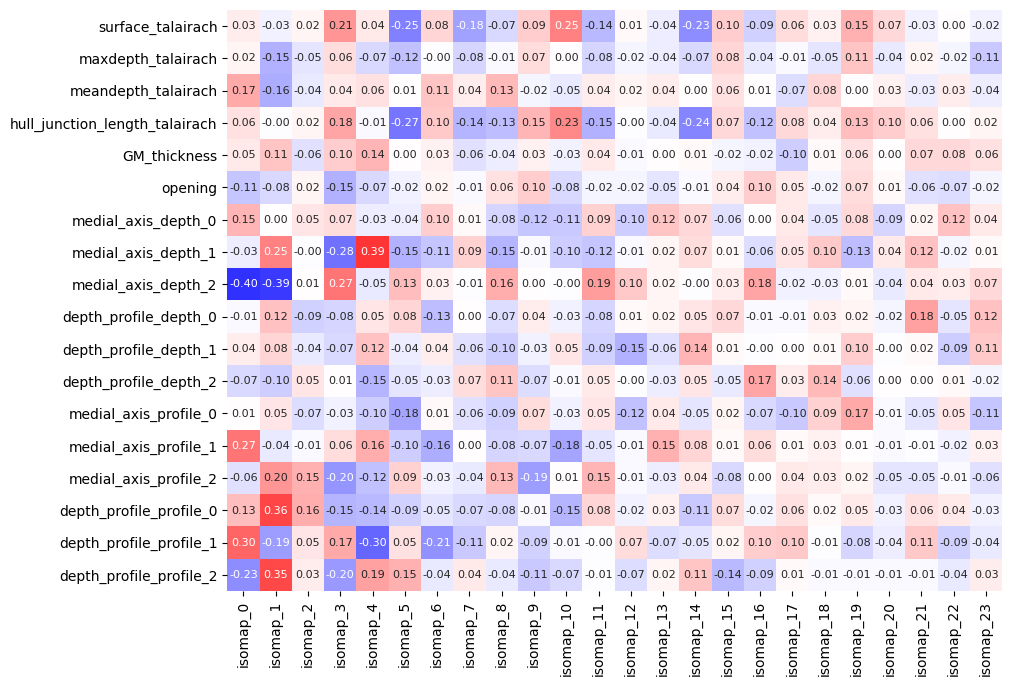

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr_df.iloc[:24, 24:].T, cmap='seismic', vmax=1, vmin=-1, ax=ax, square=True,
            annot=True, fmt='.2f', annot_kws={'fontsize': 8}, cbar=False)
plt.savefig('corr_heatmap.png', dpi=300, bbox_inches='tight',
            pad_inches=0.0)

/tmp/ipykernel_3508384/2881935565.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df2 = all_feat_df.corr()


<Axes: >

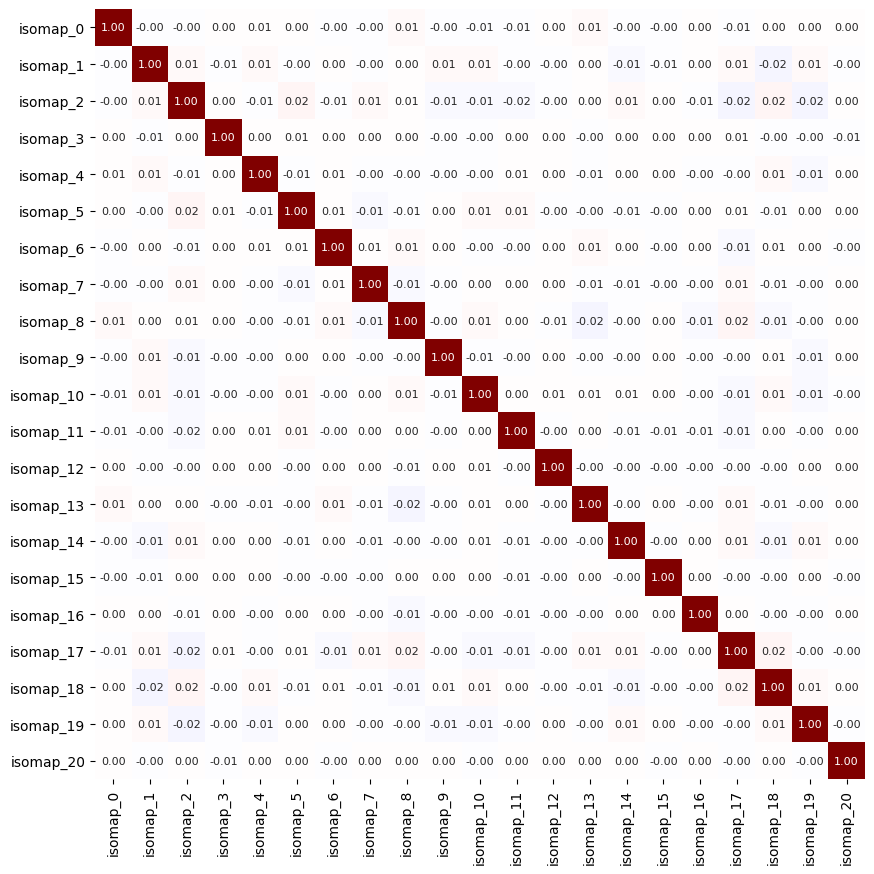

In [ ]:
corr_df2 = all_feat_df.corr()
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr_df2.iloc[:21, :21], cmap='seismic', vmax=1, vmin=-1, ax=ax, square=True,
            annot=True, fmt='.2f', annot_kws={'fontsize': 8}, cbar=False)

In [ ]:
all_feat_df.columns

Index(['isomap_0', 'isomap_1', 'isomap_2', 'isomap_3', 'isomap_4', 'isomap_5',
       'isomap_6', 'isomap_7', 'isomap_8', 'isomap_9', 'isomap_10',
       'isomap_11', 'isomap_12', 'isomap_13', 'isomap_14', 'isomap_15',
       'isomap_16', 'isomap_17', 'isomap_18', 'isomap_19', 'isomap_20',
       'isomap_21', 'isomap_22', 'isomap_23', 'subject_id', 'side',
       'handedness', 'group', 'cbcl_total', 'cbcl_external', 'cbcl_internal',
       'cgas', 'any_diagnosis', 'sex', 'surface_talairach',
       'maxdepth_talairach', 'meandepth_talairach',
       'hull_junction_length_talairach', 'GM_thickness', 'opening',
       'medial_axis_depth_0', 'medial_axis_depth_1', 'medial_axis_depth_2',
       'depth_profile_depth_0', 'depth_profile_depth_1',
       'depth_profile_depth_2', 'medial_axis_profile_0',
       'medial_axis_profile_1', 'medial_axis_profile_2',
       'depth_profile_profile_0', 'depth_profile_profile_1',
       'depth_profile_profile_2'],
      dtype='object')

In [21]:
scatter_df = all_feat_df[all_feat_df.subject_id.isin(bv_good_subj)]
scatter_df.loc[:, 'group'] = scatter_df.group.replace({1:'FHR-BP', 2:'FHR-SZ', 3:'Control'})
sns.lmplot(data=scatter_df, x='isomap_0', y='medial_axis_depth_2', hue='group',
                palette='Set1', markers = ["s", "x", "o"])
print(f'R2: {r2_score(scatter_df.medial_axis_profile_0, scatter_df.isomap_6)}')
plt.title(f'Correlation of CS medial axis depth profile with ISOMAP dimension 0: ρ={corr_df.loc["medial_axis_depth_2", "isomap_0"]:.3f}')
# plt.legend(['FHR-BP', 'FHR-SZ', 'Control'])

NameError: name 'bv_good_subj' is not defined

/tmp/ipykernel_3508384/192788856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scatter_df.loc[:, 'group'] = scatter_df.group.replace({1:'FHR-BP', 2:'FHR-SZ', 3:'Control'})


R2: -23.280647821835945


Text(0.5, 1.0, 'Correlation of CS depth profile with ISOMAP dimension 5: ρ=-0.273')

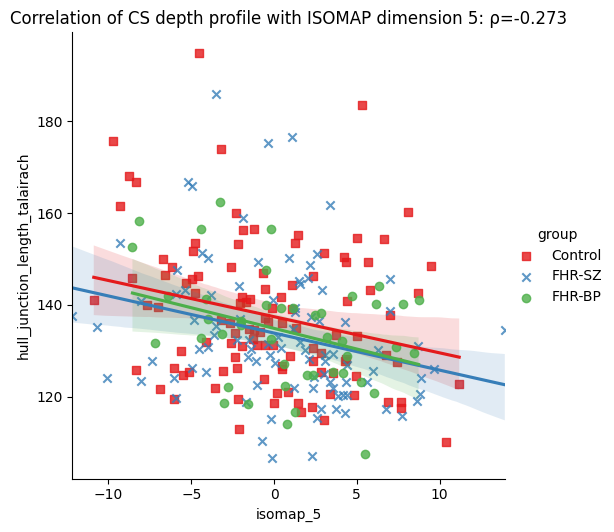

In [ ]:
scatter_df = all_feat_df[all_feat_df.subject_id.isin(bv_good_subj)]
scatter_df.loc[:, 'group'] = scatter_df.group.replace({1:'FHR-BP', 2:'FHR-SZ', 3:'Control'})
sns.lmplot(data=scatter_df, x='isomap_5', y='hull_junction_length_talairach', hue='group',
                palette='Set1', markers = ["s", "x", "o"])
print(f'R2: {r2_score(scatter_df.medial_axis_profile_0, scatter_df.isomap_6)}')
plt.title(f'Correlation of CS depth profile with ISOMAP dimension 5: ρ={corr_df.loc["hull_junction_length_talairach", "isomap_5"]:.3f}')
# plt.legend(['FHR-BP', 'FHR-SZ', 'Control'])

In [22]:
scatter_df = all_feat_df[all_feat_df.subject_id.isin(bv_good_subj)]
scatter_df.loc[:, 'group'] = scatter_df.group.replace({1:'FHR-BP', 2:'FHR-SZ', 3:'Control'})
sns.lmplot(data=scatter_df, x='isomap_1', y='depth_profile_profile_0', hue='group',
                palette='Set1', markers = ["s", "x", "o"])
print(f'R2: {r2_score(scatter_df.medial_axis_profile_0, scatter_df.isomap_6)}')
plt.title(f'Correlation of CS depth profile with ISOMAP dimension 1: ρ={corr_df.loc["depth_profile_profile_0", "isomap_1"]:.3f}')
# plt.legend(['FHR-BP', 'FHR-SZ', 'Control'])

NameError: name 'bv_good_subj' is not defined

/tmp/ipykernel_3508384/2836677092.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_df_target.style.background_gradient(cmap='seismic', vmax=1, vmin=-1).set_precision(3)


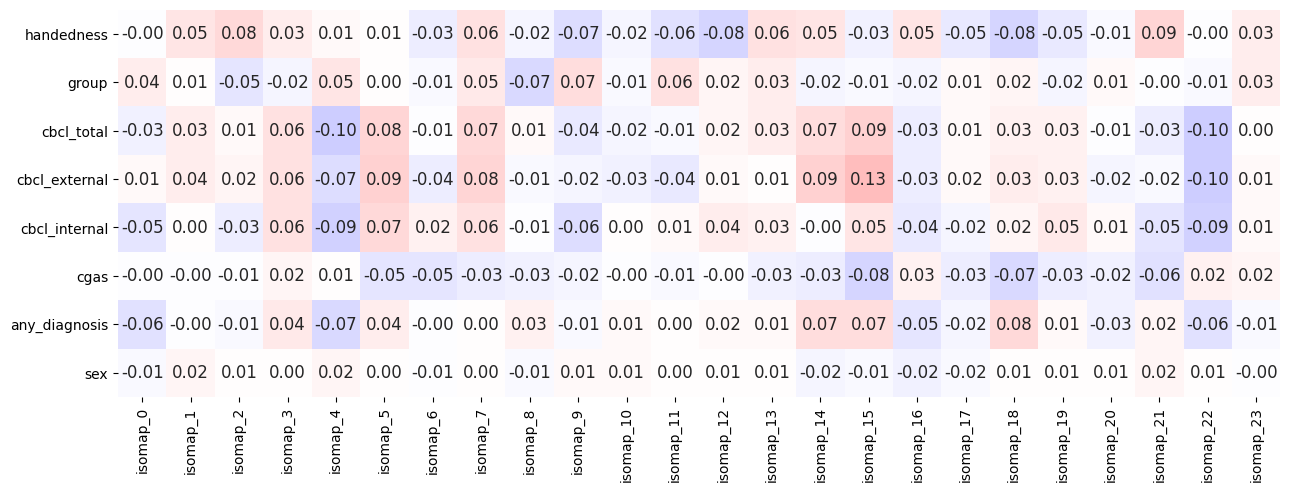

In [ ]:
corr_df_target = all_feat_df
corr_df_target = corr_df_target.drop(columns=['subject_id', 'side']).corr(numeric_only=False)
corr_df_target.style.background_gradient(cmap='seismic', vmax=1, vmin=-1).set_precision(3)
fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(corr_df_target.iloc[24:32, :24], cmap='seismic', vmax=1, vmin=-1, ax=ax, square=True,
            annot=True, fmt='.2f', annot_kws={'fontsize': 12}, cbar=False)
plt.show()

#### Select only righ-handed individuals

A Wilcoxon signed-rank test to investigate whether the two age- or hemisphere-groups differed in positioning on a specific dimension (suggesting a difference in the shape of the sulci throughout development or between hemispheres), and a Spearman correlation to assess whether the two age- or hemisphere-groups showed correlated shape features (suggesting early and stable shape patterns throughout development or between the hemispheres). We conducted these tests between ages for each hemisphere (L30 vs L40, R30 vs R40), and between hemispheres at each age (L30 vs R30, L40 vs R40). Applying a correction for multiple comparisons with the Bonferroni approach would have led to a statistical threshold at 0.00125 for an alpha level at 0.05 because of the 40 tests performed (4 age-and-hemisphere-specific tests x 10 dimensions tested). However, as the Bonferroni method may be considered as too restrictive, we focused on results with p-values under the threshold computed for each age-and-hemisphere-specific test, thus only compensating for the number of dimensions, resulting in a statistical threshold at 0.005. Only the results with p-values below or in the same range as this corrected threshold are described in the Results section. The whole test results are available in Sup. Info., Table 3 for Wilcoxon signed rank tests and Table 4 for Spearman correlations.

In [23]:
control_subjects = all_feat_df[all_feat_df.group == 3].subject_id.unique()
fhr_bp = all_feat_df[all_feat_df.group == 1].subject_id.unique()
fhr_sz = all_feat_df[all_feat_df.group == 2].subject_id.unique()
right_handed_subjects = all_feat_df[(all_feat_df.handedness==3)].subject_id.unique()

left_mask = (all_feat_df.side == 'left').values

right_handed = np.unique(eda_df[eda_df.handedness == 3].index.values)
left_handed = np.unique(eda_df[eda_df.handedness == 1].index.values)

In [24]:
len(control_subjects), len(fhr_bp), len(fhr_sz), sum(left_mask), len(right_handed)

(120, 62, 104, 286, 258)

In [37]:
PVAL_THR = 0.05

# function two test difference between two groups
# test if L differs from the right in the same group AND the diffrence is different between groups
# just test if L/R/ differs from the right in the same group
# select right handed subjects
for id in isomap_features.columns[:-2]:

    control_group_l = all_feat_df.loc[(all_feat_df.subject_id.isin(control_subjects)\
                                       &(left_mask)\
                                       &(all_feat_df.subject_id.isin(right_handed))), id].values
    fhr_bp_group_l = all_feat_df.loc[(all_feat_df.subject_id.isin(fhr_bp)\
                                       &(left_mask)\
                                       &(all_feat_df.subject_id.isin(right_handed))), id].values
    fhr_sz_group_l = all_feat_df.loc[(all_feat_df.subject_id.isin(fhr_sz)\
                                       &(left_mask)\
                                       &(all_feat_df.subject_id.isin(right_handed))), id].values

    control_group_r = all_feat_df.loc[(all_feat_df.subject_id.isin(control_subjects)\
                                       &(~left_mask)\
                                       &(all_feat_df.subject_id.isin(right_handed))), id].values
    fhr_bp_group_r = all_feat_df.loc[(all_feat_df.subject_id.isin(fhr_bp)\
                                       &(~left_mask)\
                                       &(all_feat_df.subject_id.isin(right_handed))), id].values
    fhr_sz_group_r = all_feat_df.loc[(all_feat_df.subject_id.isin(fhr_sz)\
                                       &(~left_mask)\
                                       &(all_feat_df.subject_id.isin(right_handed))), id].values
    
    
    side_tests = [('control_group_l-vs-control_group_r',(control_group_l, control_group_r)),
                  ('fhr_bp_group_l-vs-fhr_bp_group_r',(fhr_bp_group_l, fhr_bp_group_r)),
                  ('fhr_sz_group_l-vs-fhr_sz_group_r',(fhr_sz_group_l, fhr_sz_group_r)),
                  ]
    
    left_group_comp = [('fhr_bp_group_l-control_group_l', (fhr_bp_group_l, control_group_l)),
                       ('fhr_sz_group_l-fhr_bp_group_l', (fhr_sz_group_l, fhr_bp_group_l)),
                     ('control_group_l-fhr_sz_group_l', (control_group_l, fhr_sz_group_l)),
                     ]

    right_group_comp = [('fhr_bp_group_r-control_group_r', (fhr_bp_group_r, control_group_r)),
                        ('fhr_sz_group_r-fhr_bp_group_r', (fhr_sz_group_r, fhr_bp_group_r)),
                        ('control_group_r-fhr_sz_group_r', (control_group_r, fhr_sz_group_r)),
                        ]


    # check L/R differences between groups
    print(f'ISOMAP feature {id}')
    
    printed = False
    for tname, tpair in side_tests:
        stst, pval = wilcoxon(*tpair)
        if pval<PVAL_THR:
            if not printed:
                print('\tL/R differences between groups')
            printed = True
            print(f'\t\t {tname}: Wilcoxon signed-rank test: pval={pval:.9f} at {id}')
    
    printed = False
    for tname, tpair in left_group_comp:
        stst, pval = ttest_ind(*tpair)
        if pval<PVAL_THR:
            if not printed:
                print('\t L differences within groups')
            printed = True
            print(f'\t\t {tname}: pval={pval:.9f} at {id}')
    
    prirnted = False
    for tname, tpair in right_group_comp:
        stst, pval = ttest_ind(*tpair)
        if pval<PVAL_THR:
            if not prirnted:
                print('\t R differences within groups')
            prirnted = True
            print(f'\t\t {tname}: pval={pval:.9f} at {id}')
    
    
    stst, pval = f_oneway(control_group_l, fhr_bp_group_l, fhr_sz_group_l)
    if pval<PVAL_THR:
        print('ANOVA difference between all groups for L sulci')
        print(f'\t\t L: pval={pval:.9f} at {id}')
    
    stst, pval = f_oneway(control_group_r, fhr_bp_group_r, fhr_sz_group_r)
    if pval<PVAL_THR:
        print('ANOVA difference between all groups for R sulci')
        print(f'\t\t R: pval={pval:.9f} at {id}')
    print('*'*100)

ISOMAP feature isomap_0
	L/R differences between groups
		 control_group_l-vs-control_group_r: Wilcoxon signed-rank test: pval=0.000018452 at isomap_0
		 fhr_sz_group_l-vs-fhr_sz_group_r: Wilcoxon signed-rank test: pval=0.000012908 at isomap_0
	 R differences within groups
		 fhr_sz_group_r-fhr_bp_group_r: pval=0.027876488 at isomap_0
****************************************************************************************************
ISOMAP feature isomap_1
	L/R differences between groups
		 control_group_l-vs-control_group_r: Wilcoxon signed-rank test: pval=0.007450710 at isomap_1
		 fhr_bp_group_l-vs-fhr_bp_group_r: Wilcoxon signed-rank test: pval=0.022802403 at isomap_1
		 fhr_sz_group_l-vs-fhr_sz_group_r: Wilcoxon signed-rank test: pval=0.000016798 at isomap_1
****************************************************************************************************
ISOMAP feature isomap_2
	L/R differences between groups
		 control_group_l-vs-control_group_r: Wilcoxon signed-rank test: pv

In [30]:
palette = sns.color_palette("muted")
slope_pallete = sns.color_palette('coolwarm', n_colors=12)[1:]


def create_box_plot_with_lines(data, isom, ax):
    # Extract data for plotting
    subjects = list(data.keys())
    left_values, right_values = zip(*data.values())
    

    slps = (np.array(right_values) - np.array(left_values)).flatten()
    h, bin_edges = np.histogram(slps, 9)
    slopes = np.digitize(slps, bin_edges)
    # Create a figure and axes

    # Plot scattered points and lines
    for i in range(len(subjects) - 1):
        # ax.plot([0, 1], [left_values[i], right_values[i]], marker='o', color='black', markersize=6)
        ax.plot([0], [left_values[i]], marker='o', color=palette[0], markersize=4)
        ax.plot([1], [right_values[i]], marker='o', color=palette[1], markersize=4)
        # print(slopes[i])
        ax.plot([0, 1], [left_values[i], right_values[i]], color=slope_pallete[slopes[i]],
                linewidth=1)

    # Set labels and title
    # ax.set_xticklabels(subjects, rotation=45, ha='right')
    ax.set_xlabel('Sulci')
    # ax.set_ylabel(f'{isom} Values')
    # ax.set_title('Scattered Points Connected by Lines (Box Plot-like)')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Right', 'Left'])


def create_box_plot_with_lines_3groups(groups, isom, ax):
    
    shift = 0
    for didx, data in enumerate(groups):
        # Extract data for plotting
        subjects = list(data.keys())
        left_values, right_values = zip(*data.values())
        

        slps = (np.array(right_values) - np.array(left_values)).flatten()
        h, bin_edges = np.histogram(slps, 9)
        slopes = np.digitize(slps, bin_edges)
        # Create a figure and axes

        # Plot scattered points and lines
        for i in range(len(subjects) - 1):
            # ax.plot([0, 1], [left_values[i], right_values[i]], marker='o', color='black', markersize=6)
            ax.plot([didx + shift], [left_values[i]], marker='o', color=palette[0], markersize=4)
            ax.plot([didx + shift + 1], [right_values[i]], marker='o', color=palette[1], markersize=4)
            # print(slopes[i])
            ax.plot([didx + shift, didx + shift + 1], [left_values[i], right_values[i]], color=slope_pallete[slopes[i]],
                    linewidth=1)
        shift+=1

    # # Set labels and title
    # # ax.set_xticklabels(subjects, rotation=45, ha='right')
    # ax.set_xlabel('Grou')
    # ax.set_ylabel(f'{isom} Values')
    # # ax.set_title('Scattered Points Connected by Lines (Box Plot-like)')
    ax.set_xticks([0.5, 2.5, 4.5])
    ax.set_xticklabels(['FHR-BP', 'FHR-SZ', 'Control'])







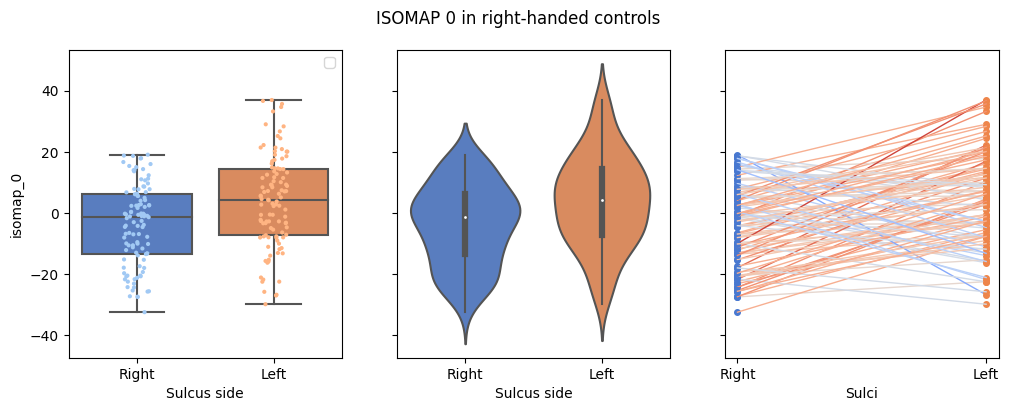

In [29]:
right_handed_df_ss = all_feat_df[(all_feat_df.subject_id.isin(right_handed_subjects)&(all_feat_df.subject_id.isin(control_subjects)))]
right_handed_df_ss = right_handed_df_ss.rename(columns={'side':'Sulcus side'})
right_handed_df_ss = right_handed_df_ss.replace({'Sulcus side':{'left':'Right', 'right':'Left'}})

for id in isomap_features.columns[:-2]:
    fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
    sns.boxplot(x='Sulcus side', y=id, data=right_handed_df_ss, palette='muted',
                ax=ax[0])
    sns.stripplot(data=right_handed_df_ss, x='Sulcus side', y=id, palette='pastel',
                  dodge=True, size=3, ax=ax[0])

    ax[0].legend([])
    sns.violinplot(x='Sulcus side', y=id, data=right_handed_df_ss, palette='muted',
                   ax=ax[1])
    ax[1].set_ylabel('')
    fig.suptitle(f'ISOMAP {id[-2:].strip("_")} in right-handed controls')
    
    data = right_handed_df_ss.groupby(['subject_id']).apply(lambda x: x[[id]].values).to_dict()
    create_box_plot_with_lines(data, id, ax=ax[2])

    
    plt.show()
    # break
    break

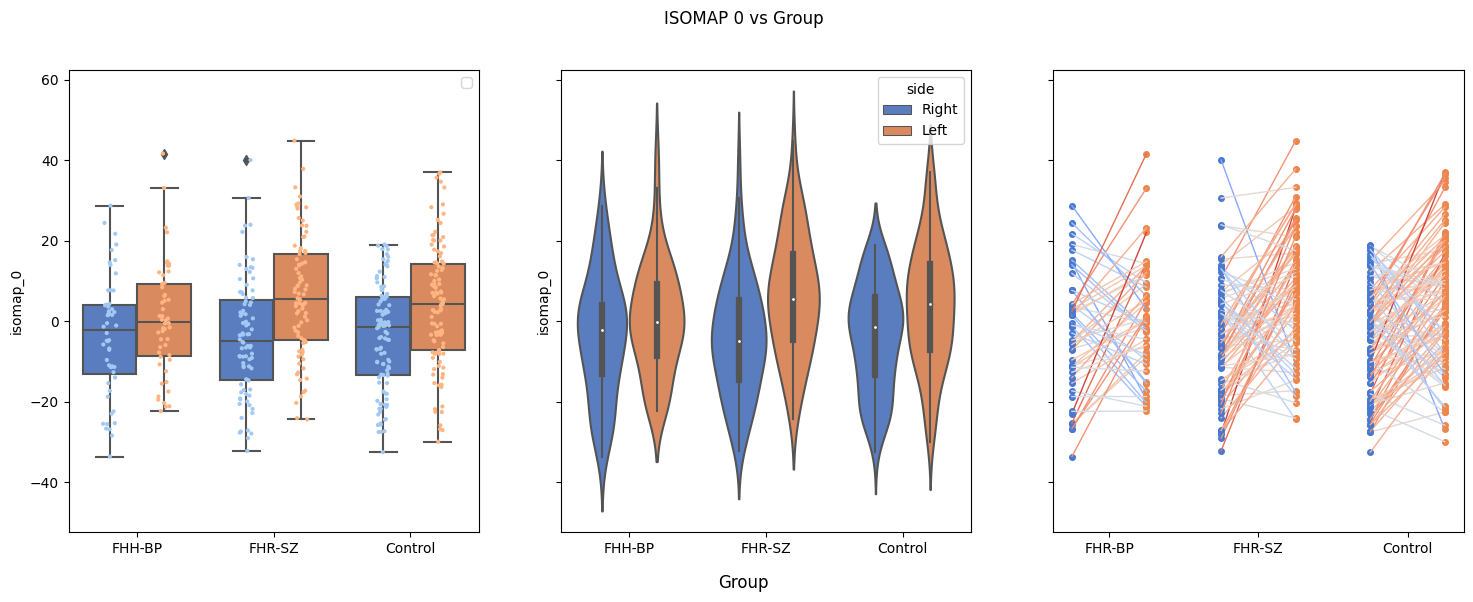

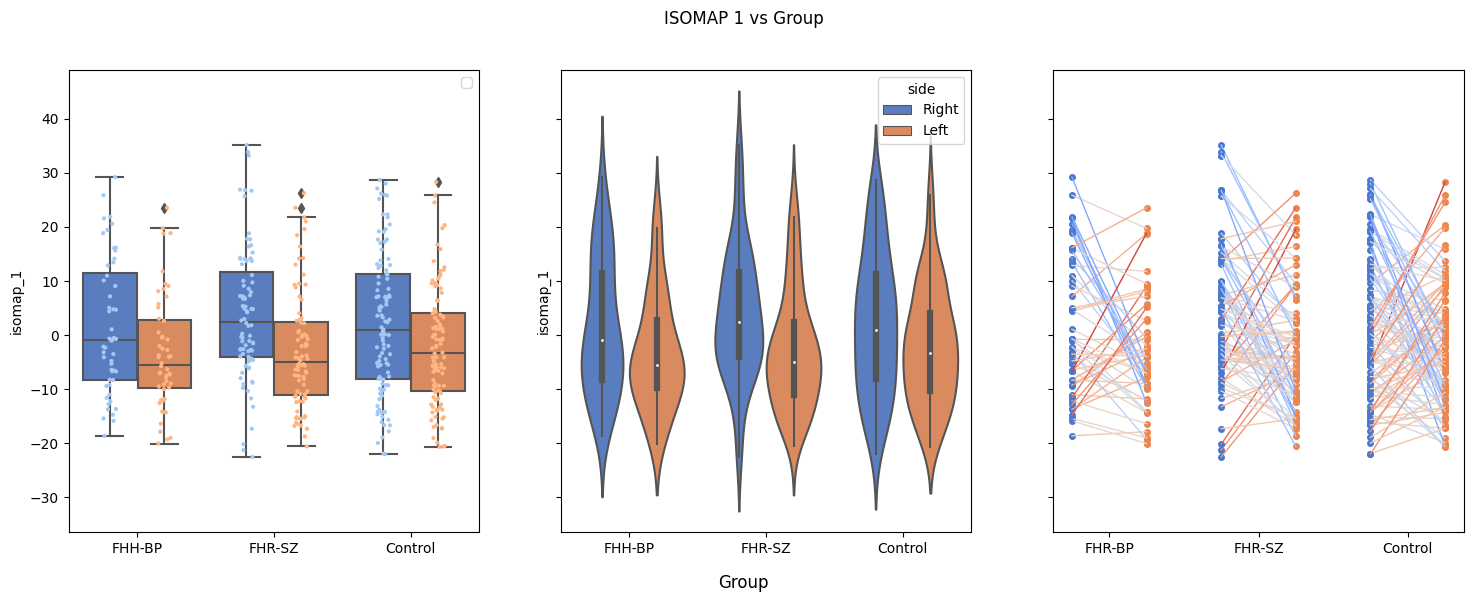

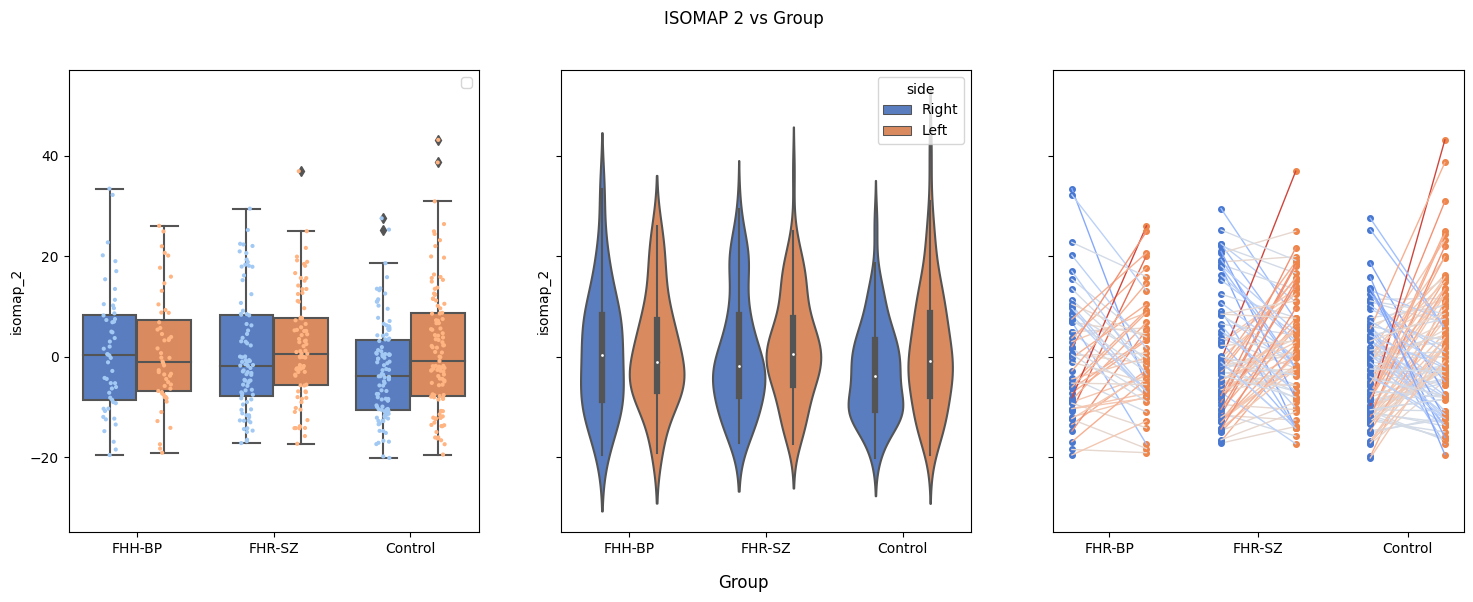

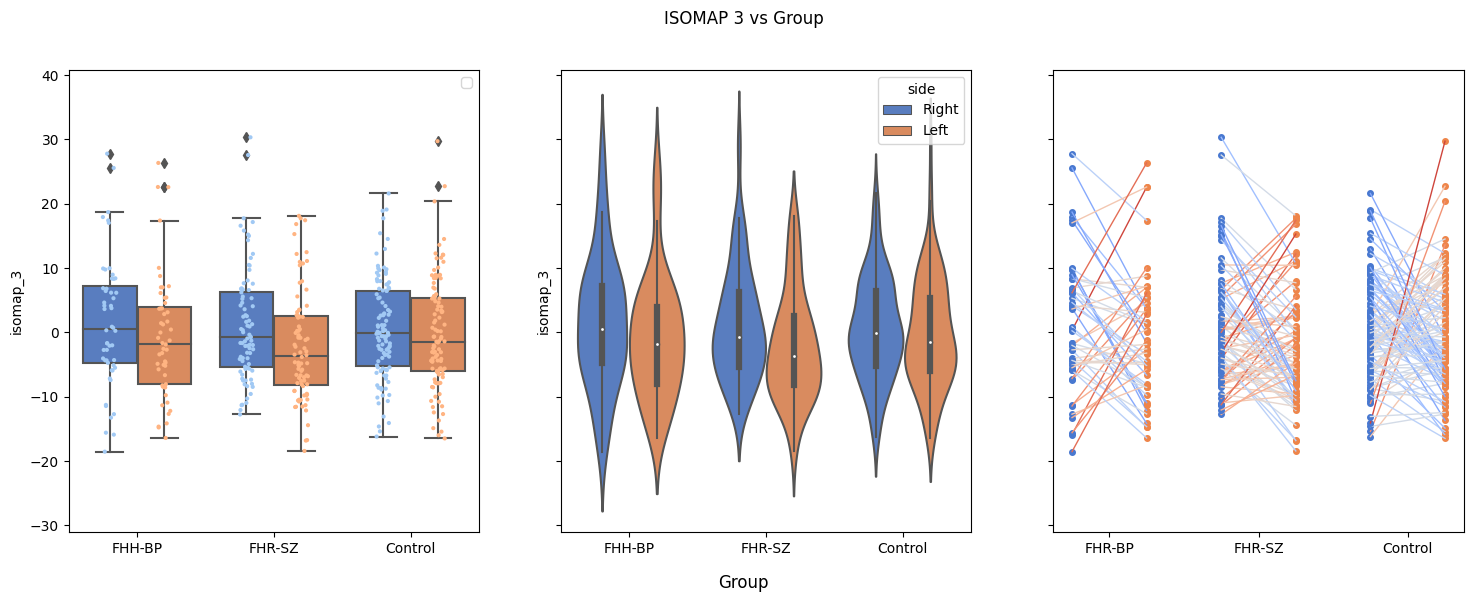

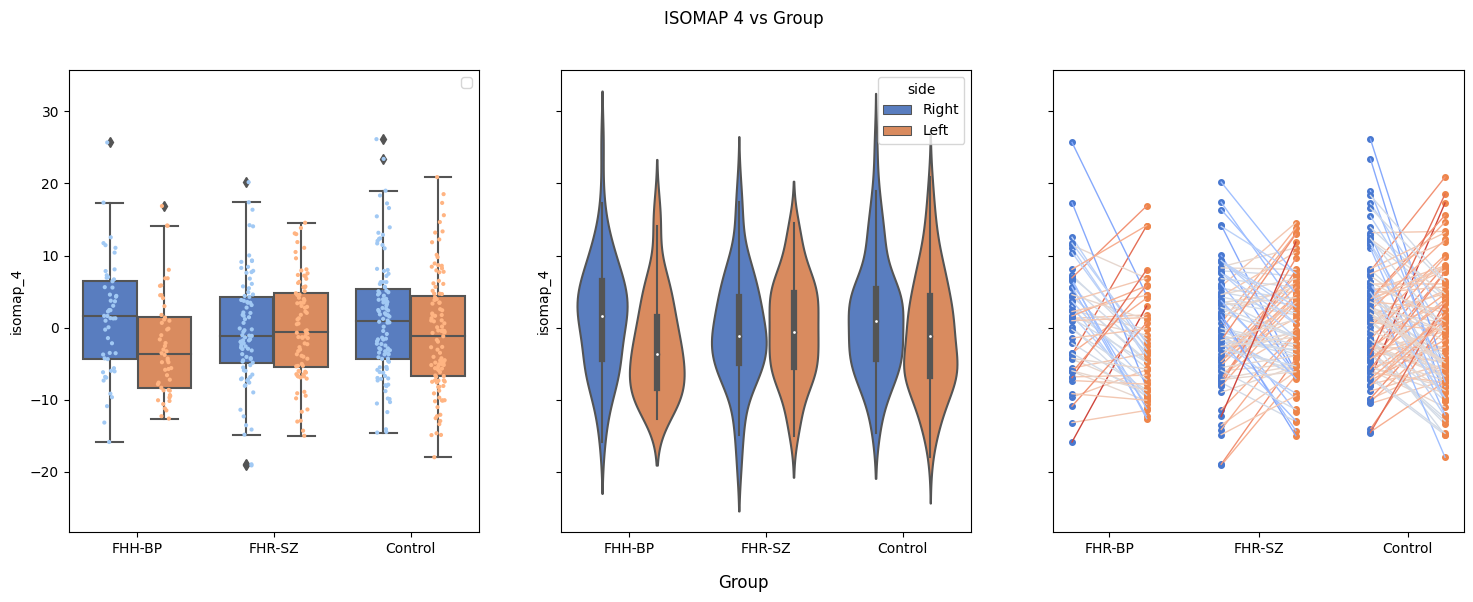

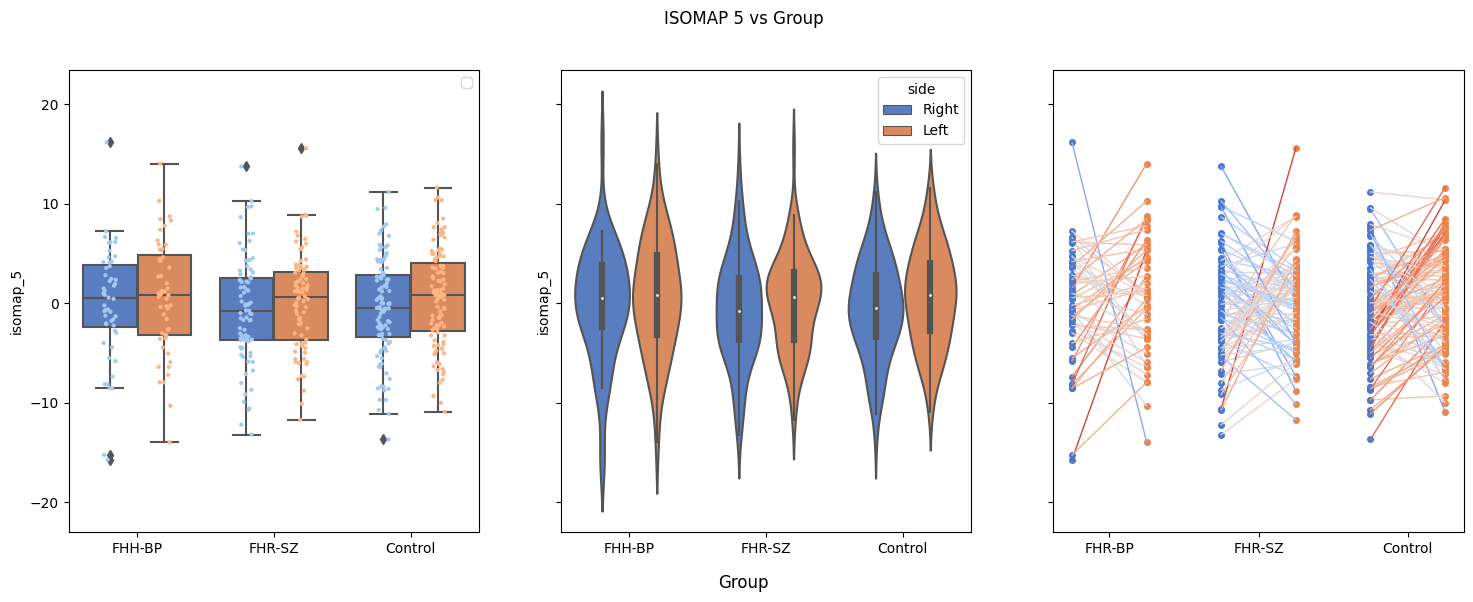

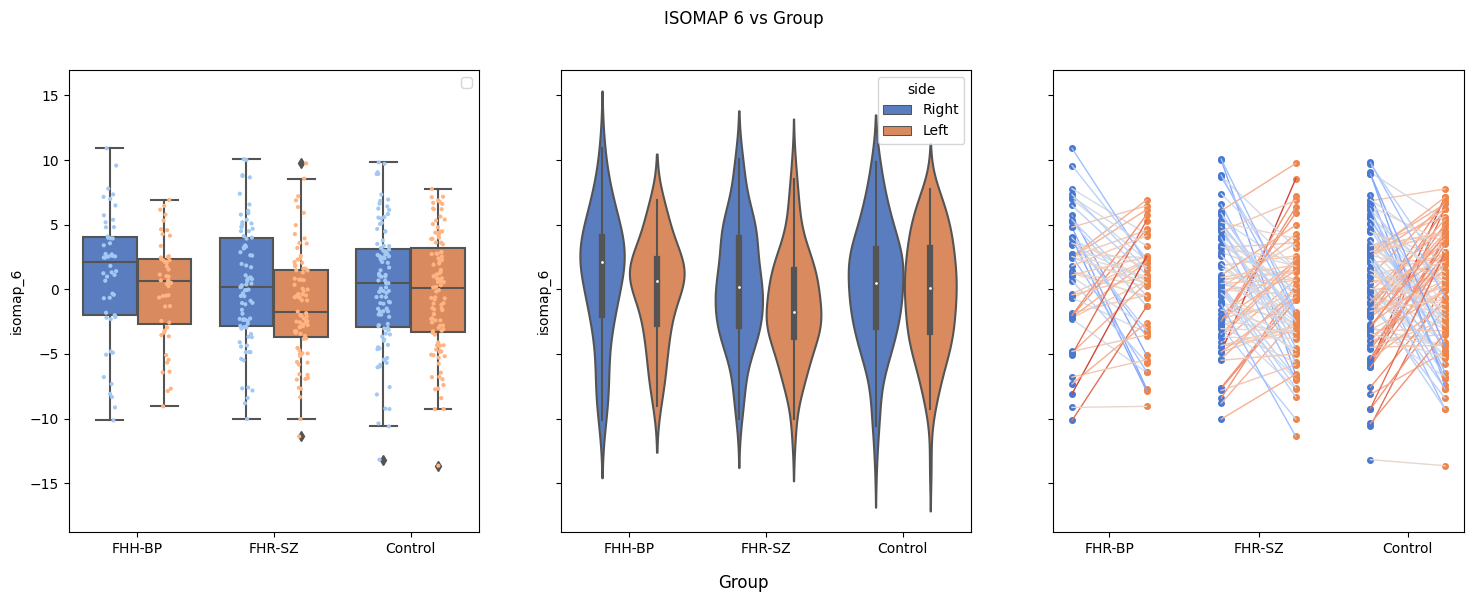

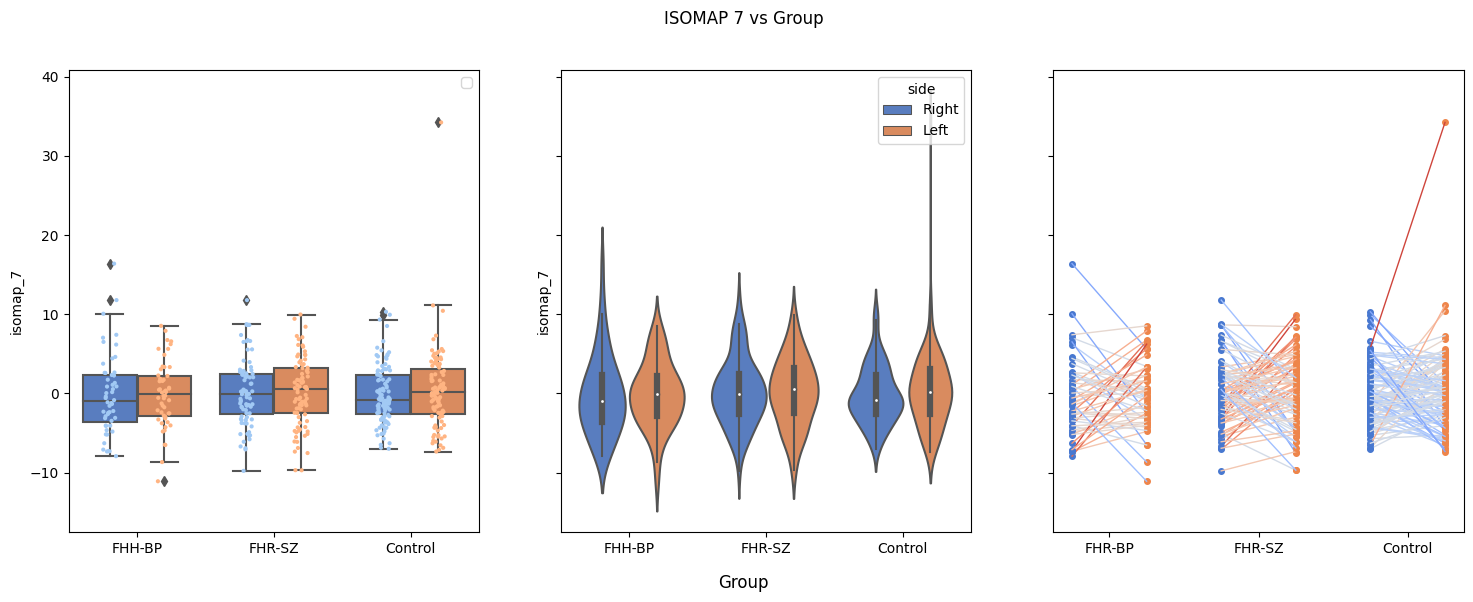

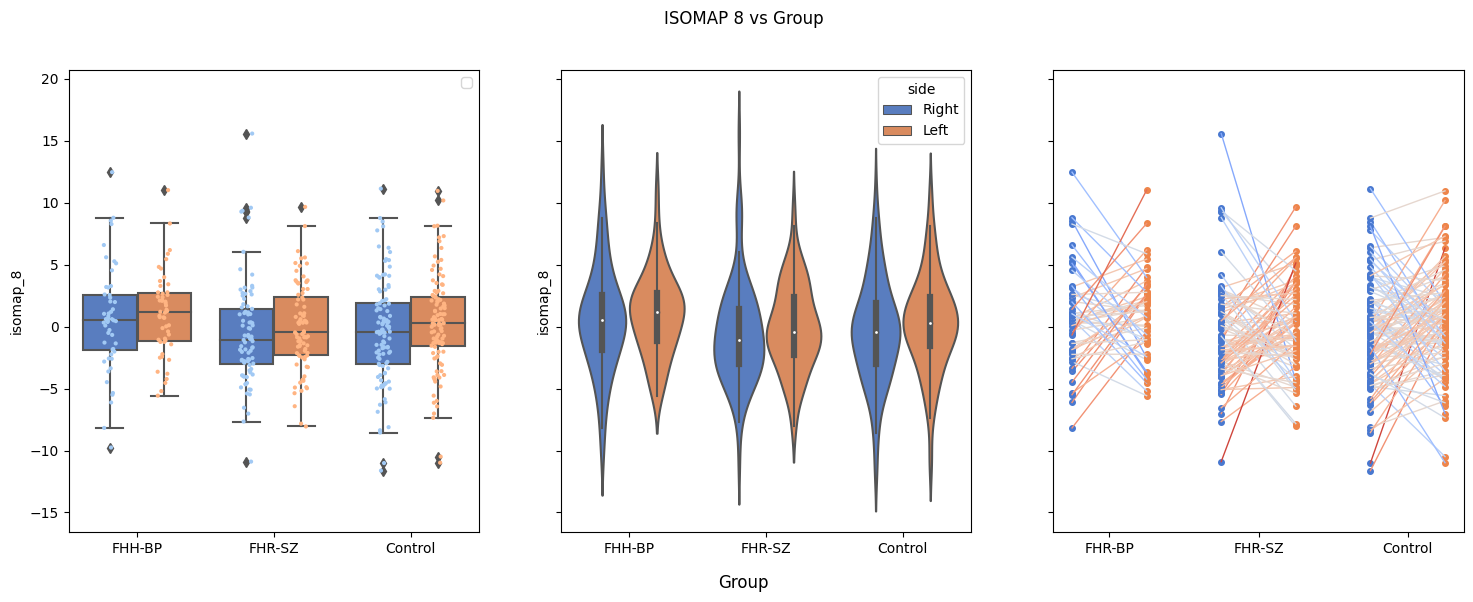

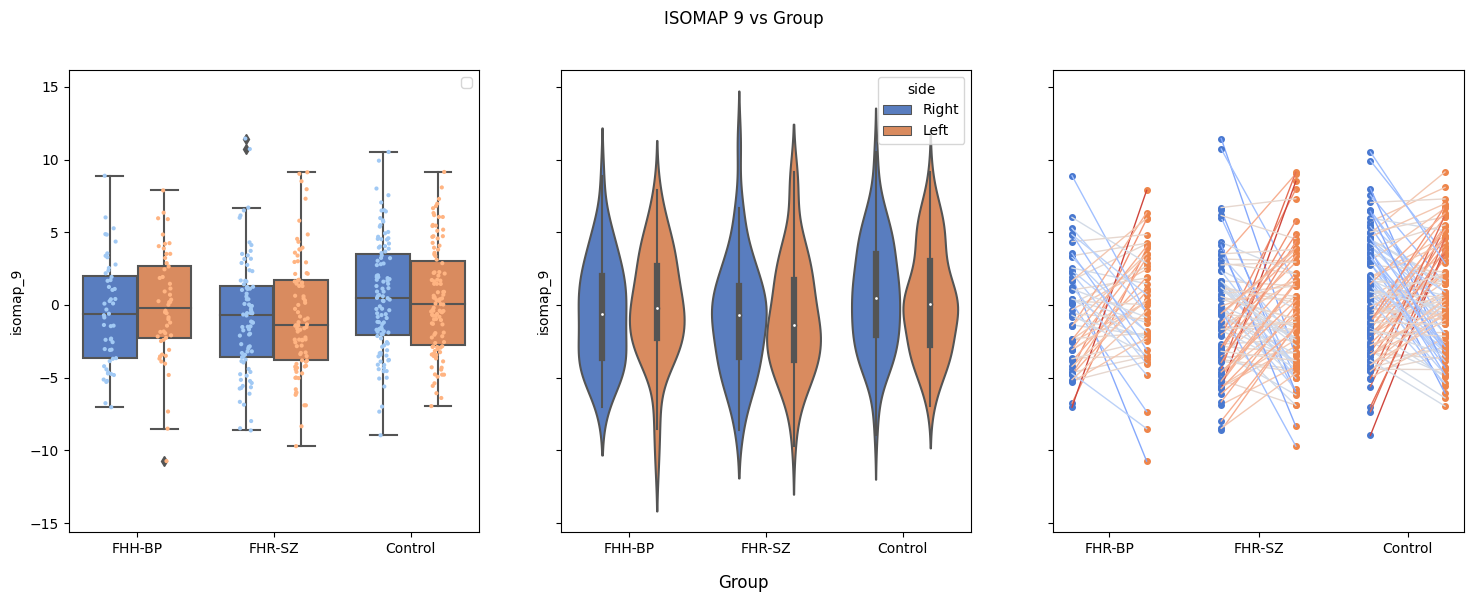

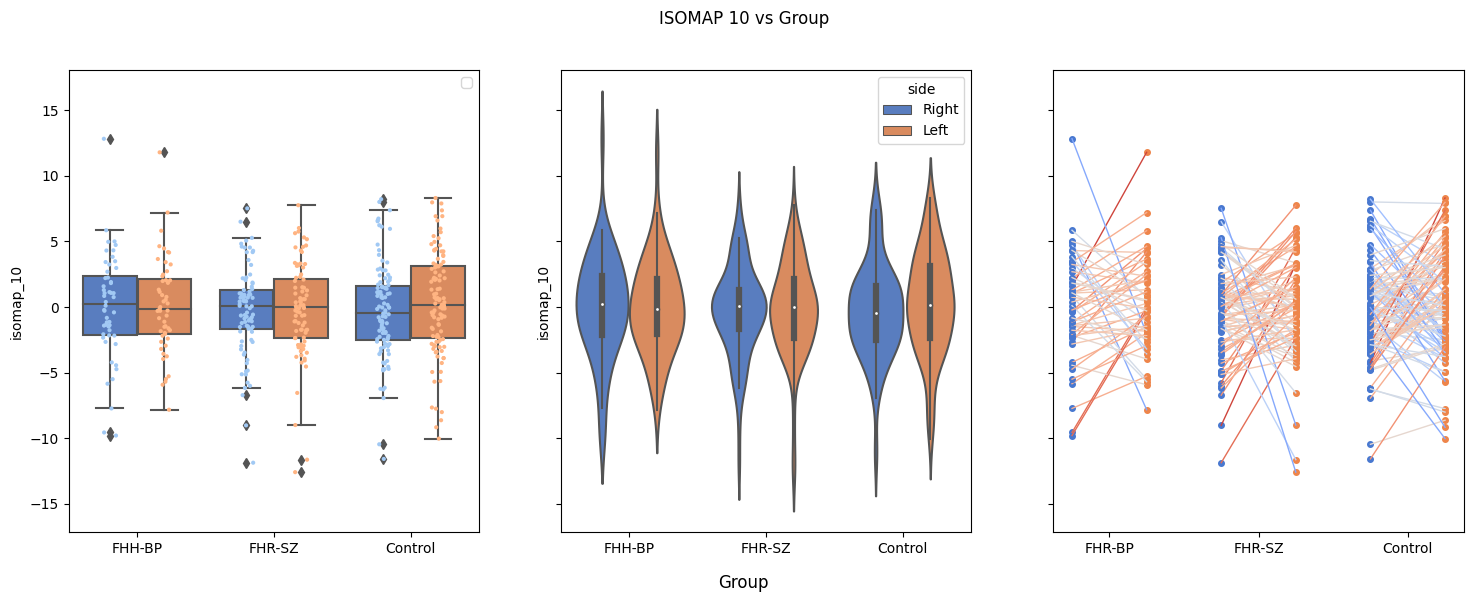

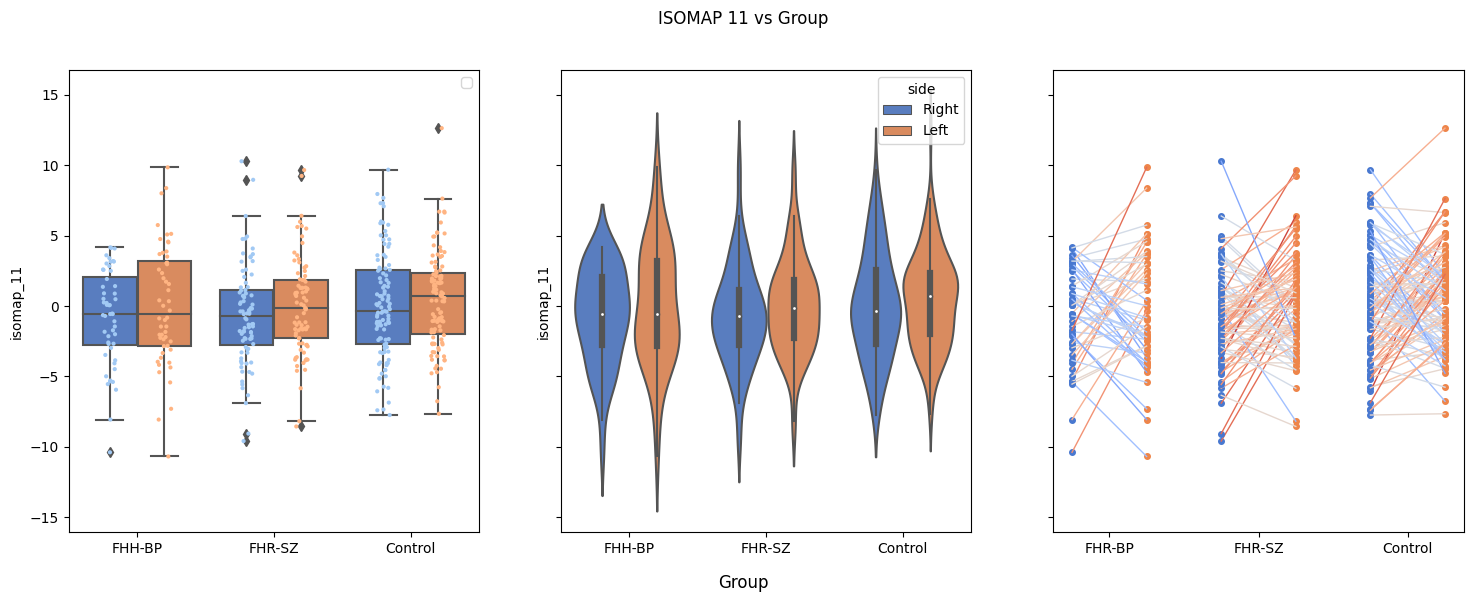

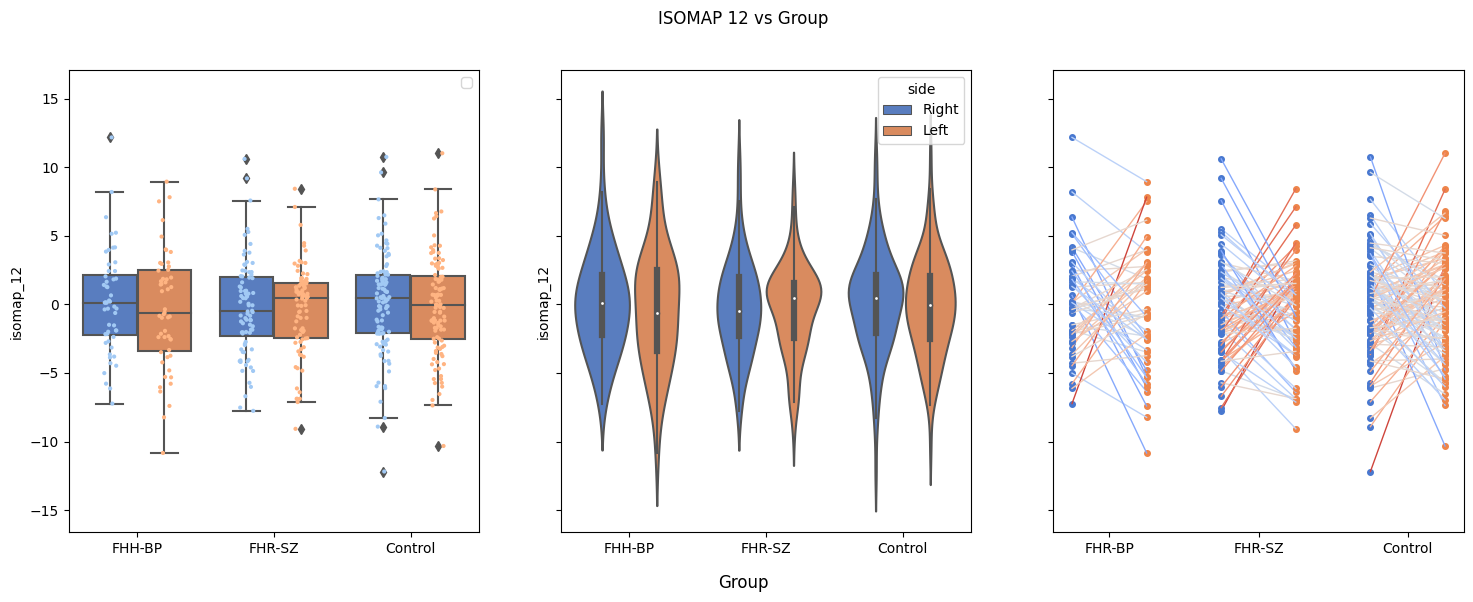

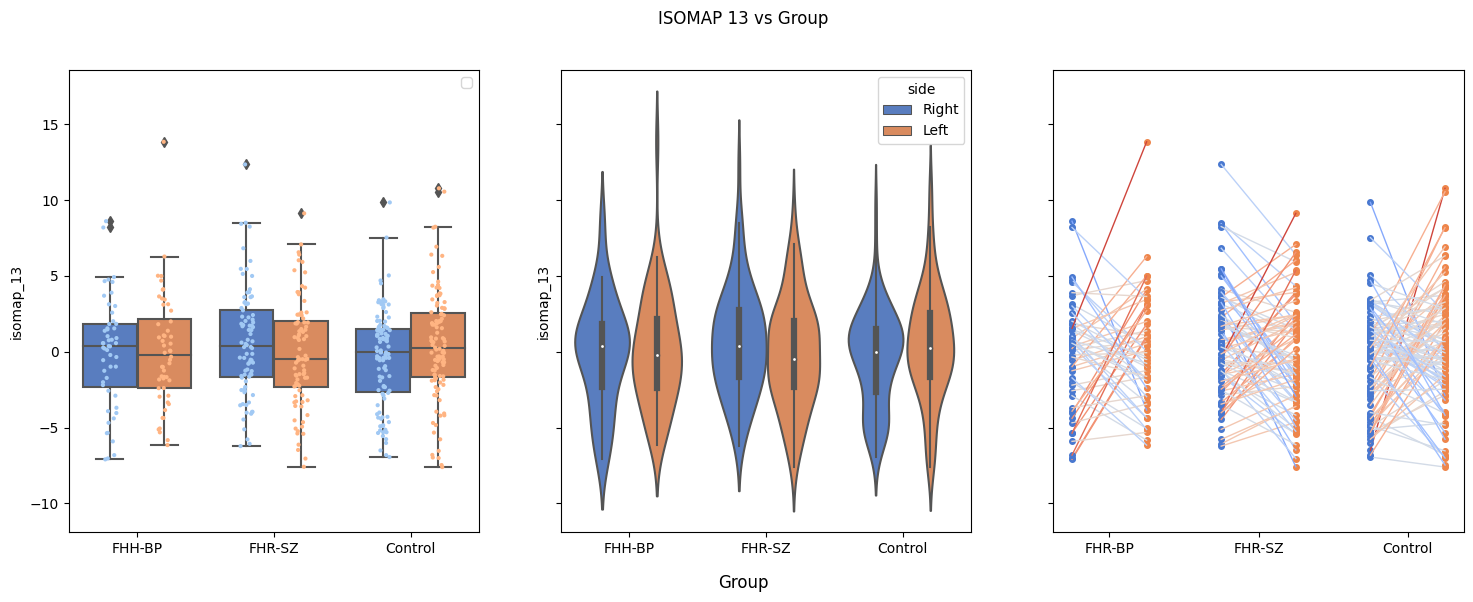

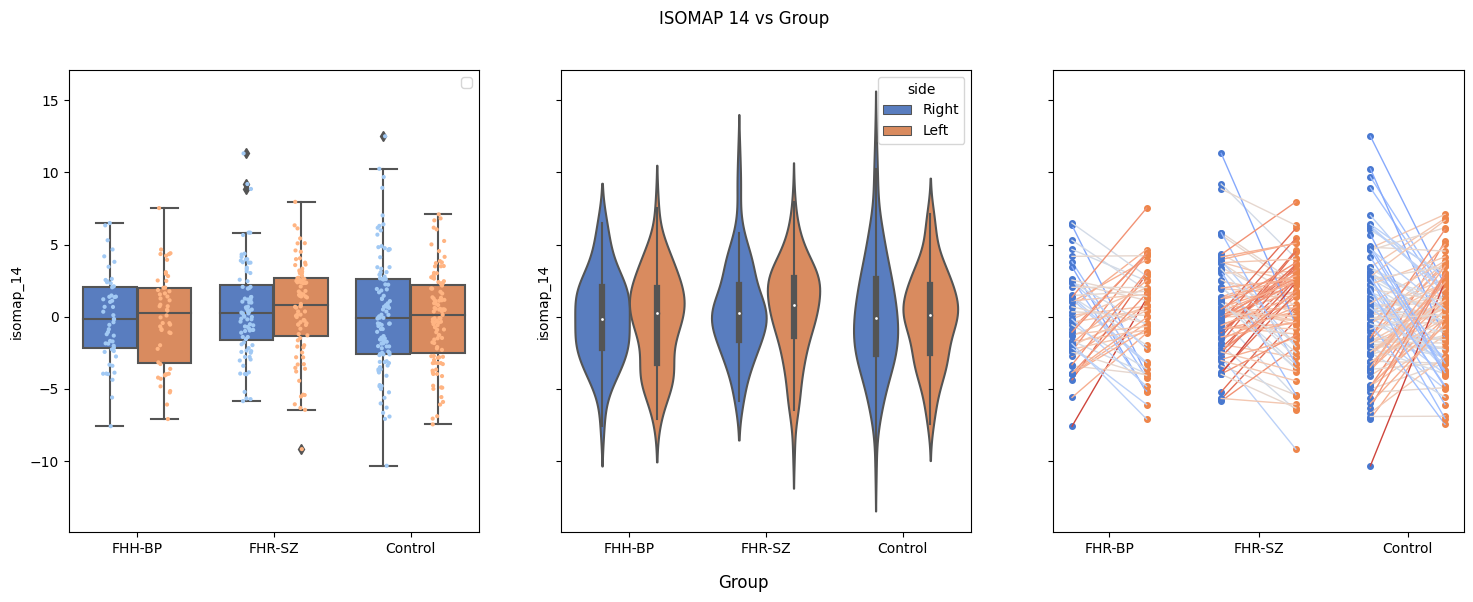

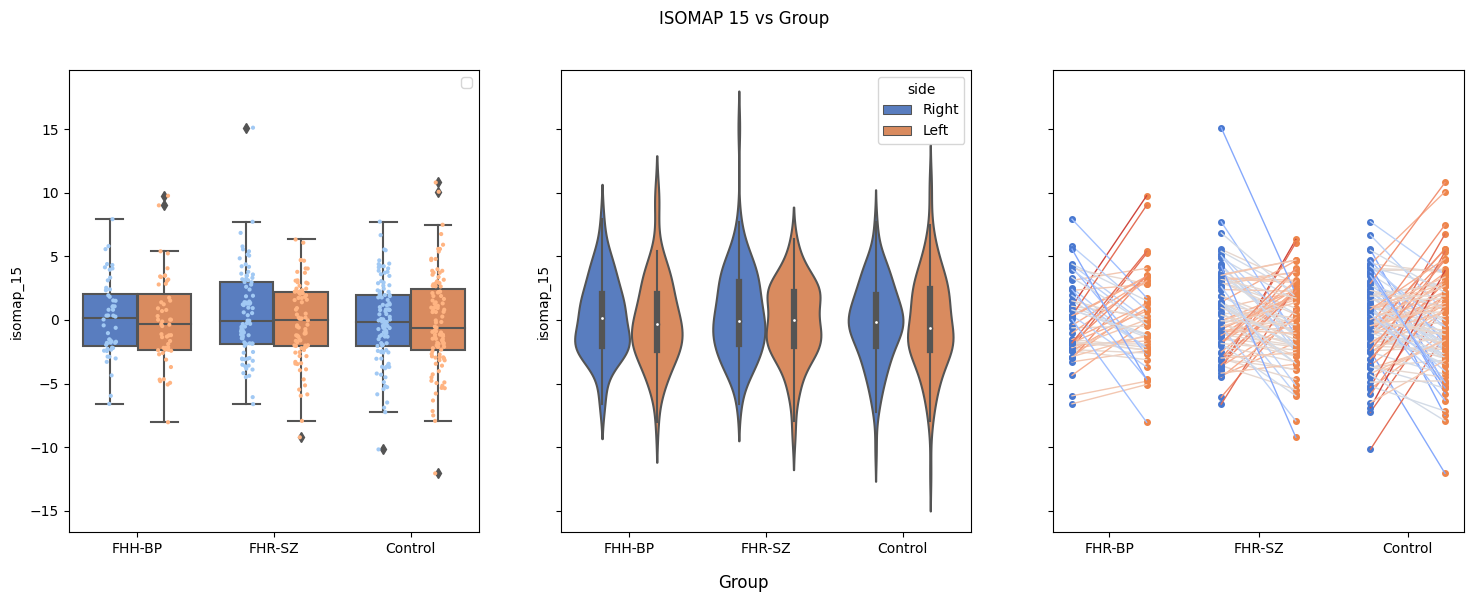

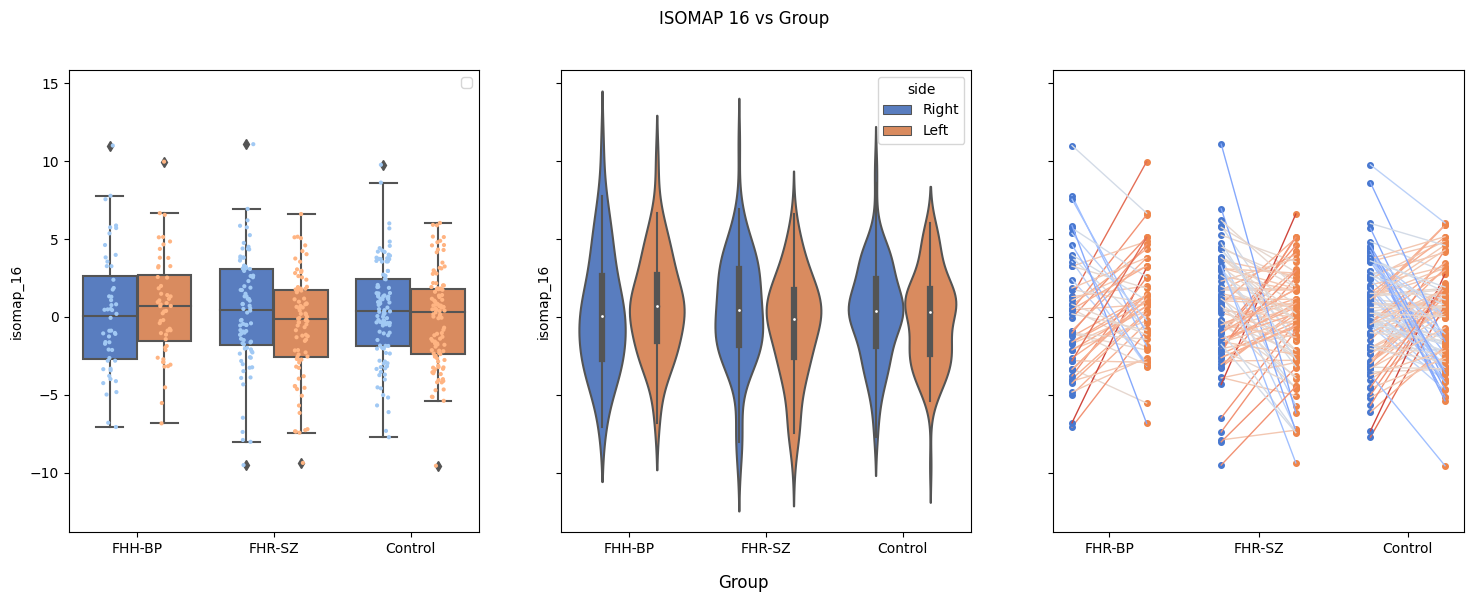

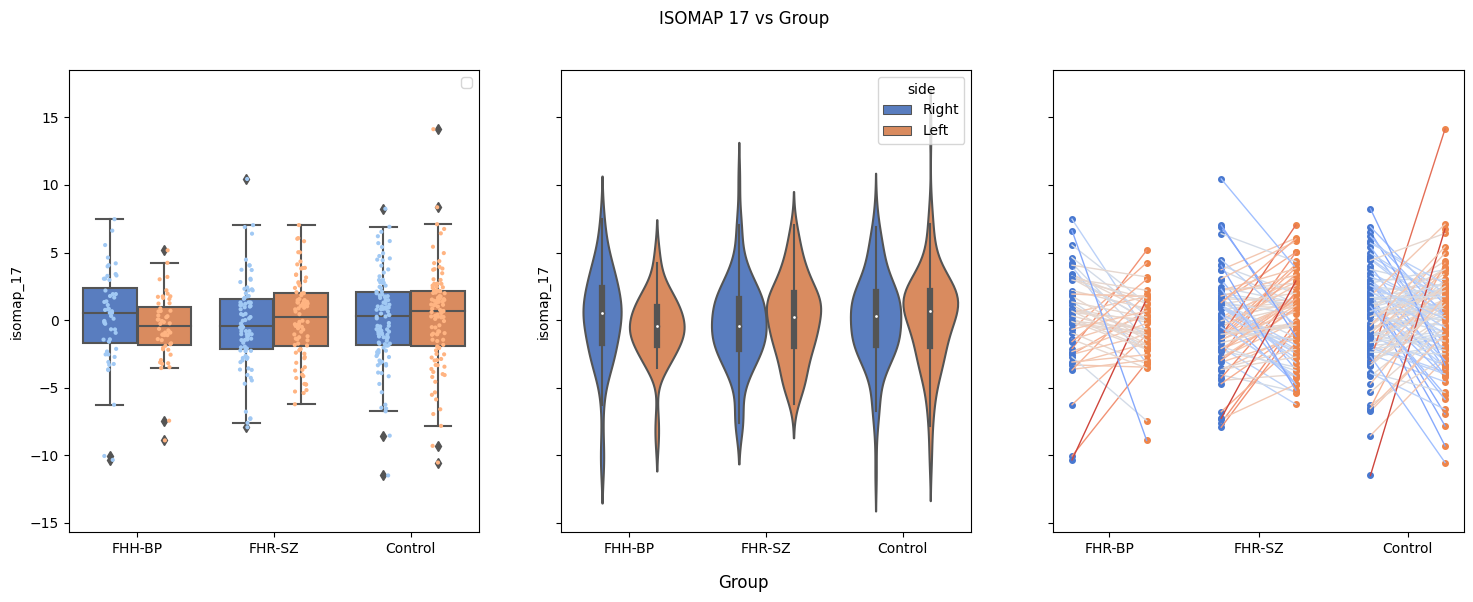

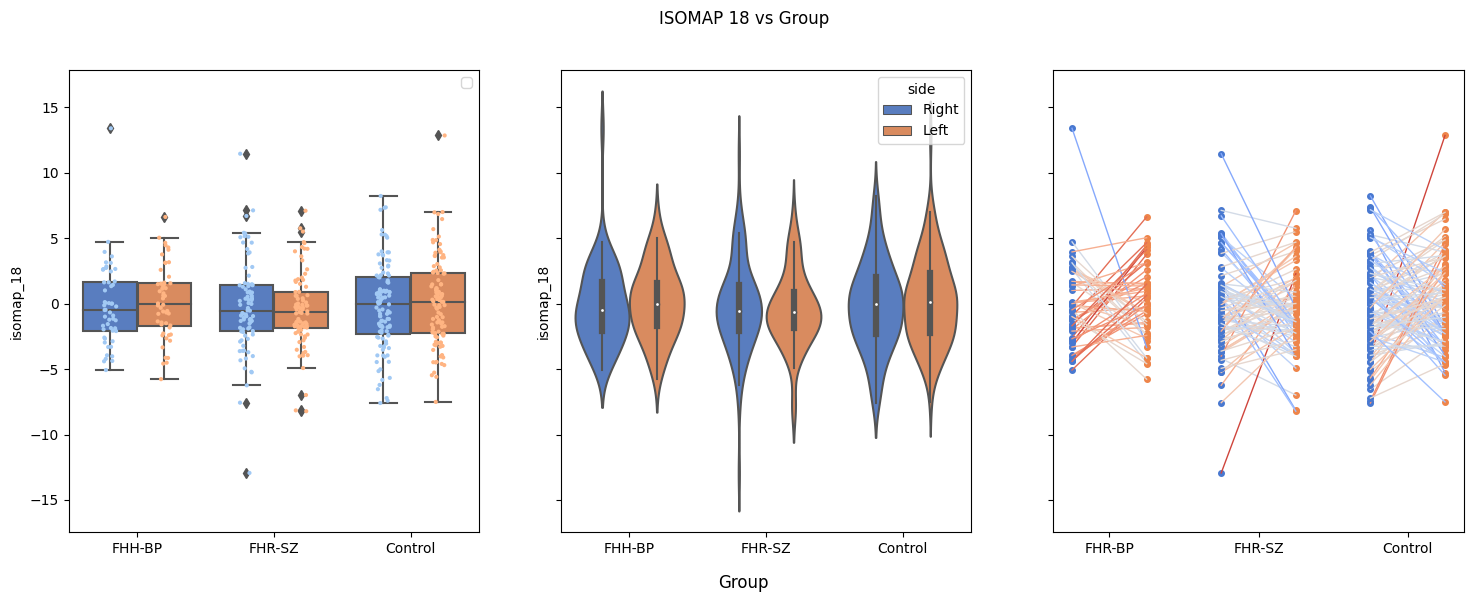

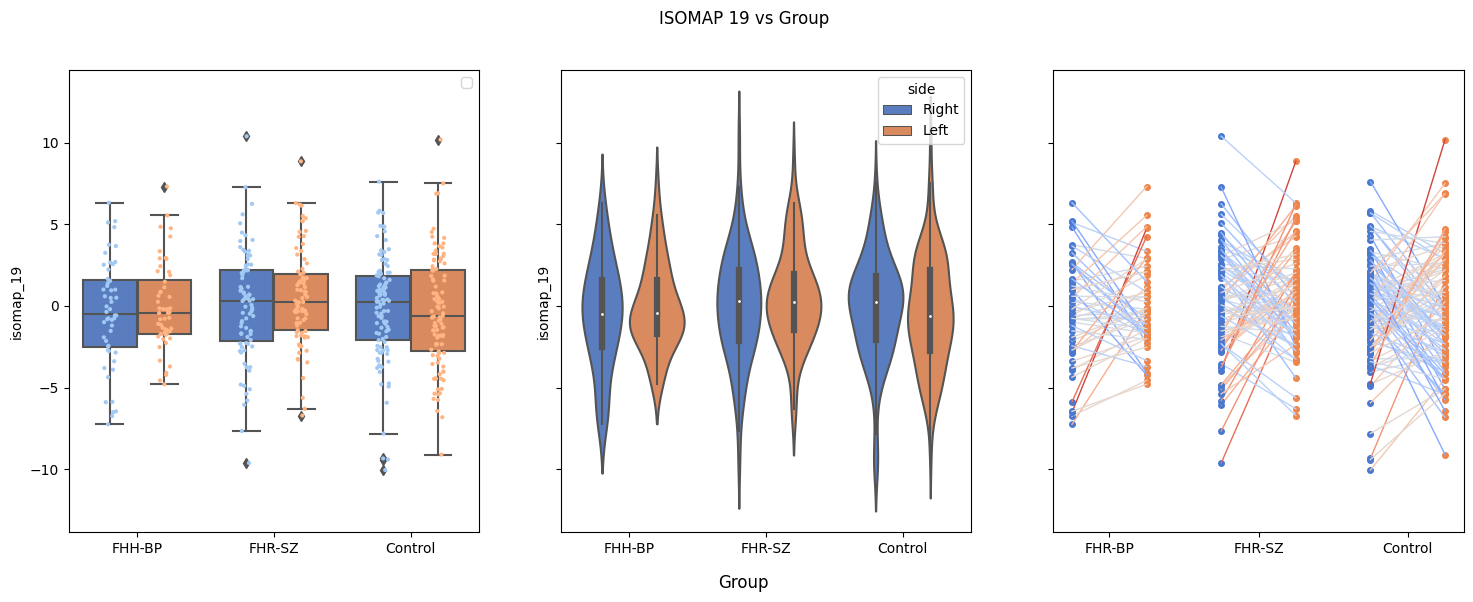

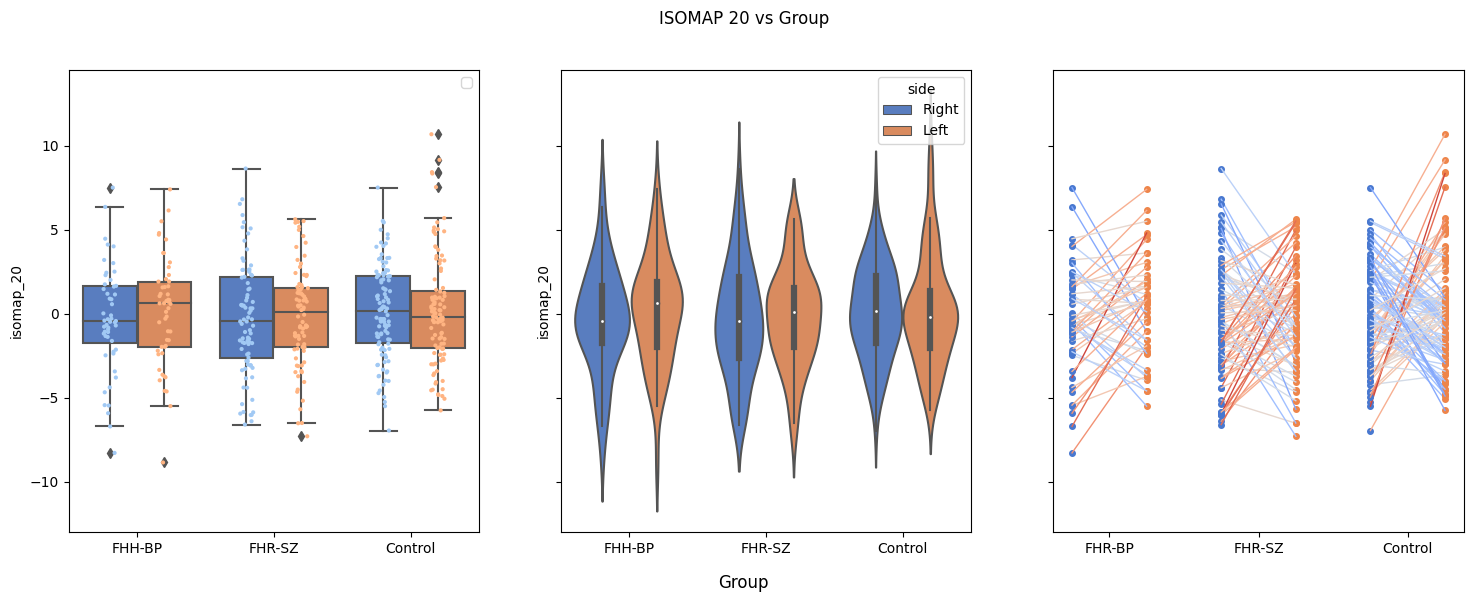

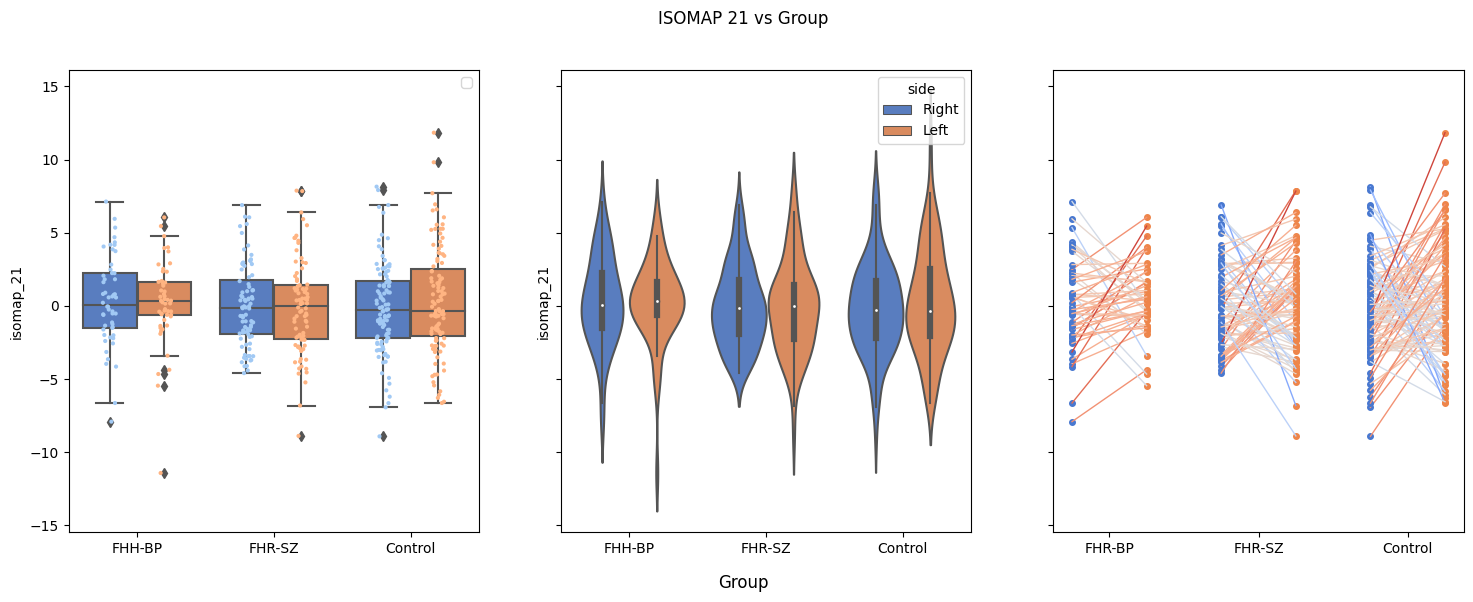

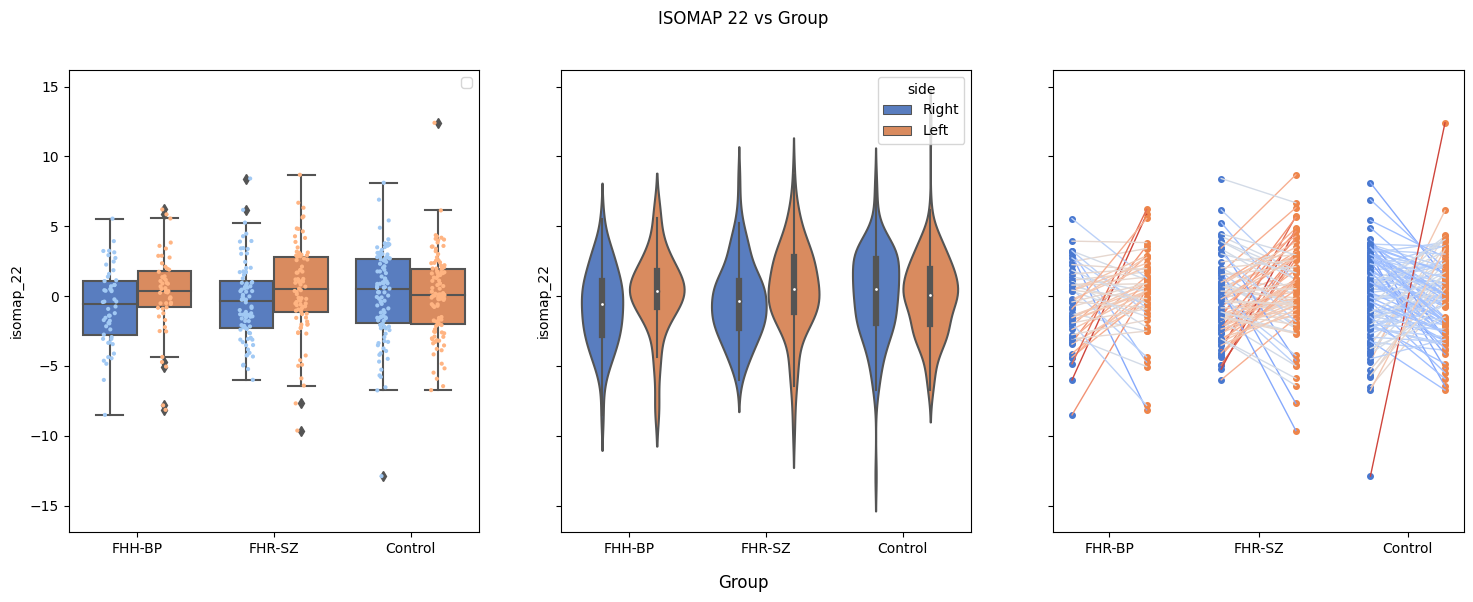

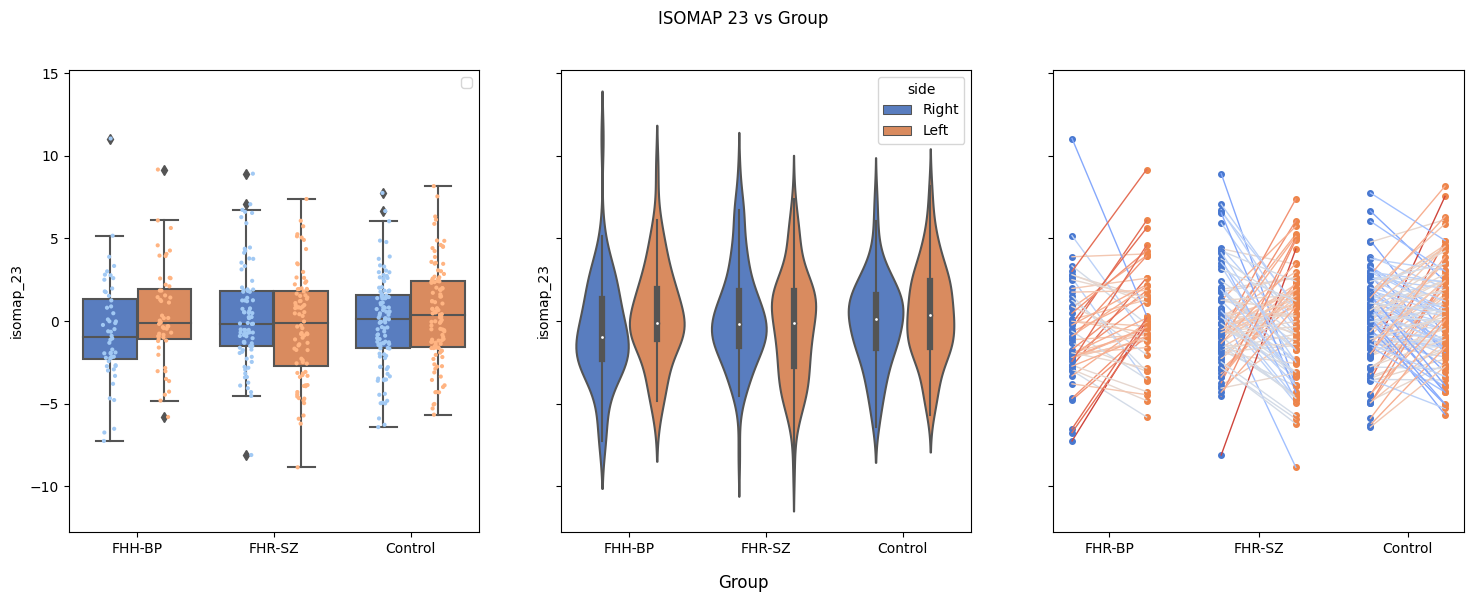

In [36]:
all_feat_df_ss = all_feat_df.replace({'side':{'left':'Right', 'right':'Left'}})
subj_groups = [all_feat_df_ss[(all_feat_df_ss.subject_id.isin(right_handed)&(all_feat_df_ss.subject_id.isin(fhr_bp)))],
               all_feat_df_ss[(all_feat_df_ss.subject_id.isin(right_handed)&(all_feat_df_ss.subject_id.isin(fhr_sz)))],
               all_feat_df_ss[(all_feat_df_ss.subject_id.isin(right_handed)&(all_feat_df_ss.subject_id.isin(control_subjects)))]
              ]

for id in isomap_features.columns[:-2]:
    fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    sns.boxplot(x='group', y=id, hue='side', data=all_feat_df_ss[all_feat_df_ss.subject_id.isin(right_handed)], palette='muted',
                ax=ax[0])
    sns.stripplot(data=all_feat_df_ss[all_feat_df_ss.subject_id.isin(right_handed)], x='group', y=id, hue='side', palette='pastel',
                  dodge=True, size=3, ax=ax[0])
    # ax[0].legend(['left', 'right'])
    ax[0].set_xticks([0, 1, 2], ['FHH-BP', 'FHR-SZ', 'Control'])
    ax[0].legend([])
    sns.violinplot(x='group', y=id, hue='side', data=all_feat_df_ss[all_feat_df_ss.subject_id.isin(right_handed)], palette='muted',
                   ax=ax[1])
    ax[1].set_xticks([0, 1, 2], ['FHH-BP', 'FHR-SZ', 'Control'])

    groups = [x.groupby(['subject_id']).apply(lambda x: x[[id]].values).to_dict() for x in subj_groups]
    create_box_plot_with_lines_3groups(groups, id, ax[2])
    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    fig.supxlabel('Group')
    fig.suptitle(f'ISOMAP {id[-2:].strip("_")} vs Group')
    plt.show()
    # break
    # break

# Predictive Modelling

In [105]:
def unwrap_side_feat(subj_df, sided_feat_names, not_sided_feat_names):
    left_f = {'l_'+k:v.values.item() for k,v in subj_df[subj_df.side == 'left'][sided_feat_names].items()}
    rigt_f = {'r_'+k:v.values.item() for k,v in subj_df[subj_df.side == 'right'][sided_feat_names].items()}
    for f in not_sided_feat_names:
        rigt_f[f] = subj_df[f].values[0]
    subj_feat = {**left_f, **rigt_f}
    subj_feat['subject_id'] = subj_df.subject_id.values[0]
    return subj_feat
    
sided_feat_names = ['isomap_0', 'isomap_1', 'isomap_2', 'isomap_3',
                    'isomap_4', 'isomap_5',
                    'isomap_6', 'isomap_7', 'isomap_8', 'isomap_9', 'isomap_10',
                    'isomap_11', 'isomap_12', 'isomap_13', 'isomap_14', 'isomap_15',
                    'isomap_16', 'isomap_17', 'isomap_18', 'isomap_19', 'isomap_20',
                    'isomap_21', 'isomap_22', 'isomap_23',
                    ]

not_sided_feat_names = ['sex', 'handedness', 'group',
                        'cbcl_total', 'cbcl_external', 'cbcl_internal',
                        'any_diagnosis']

100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


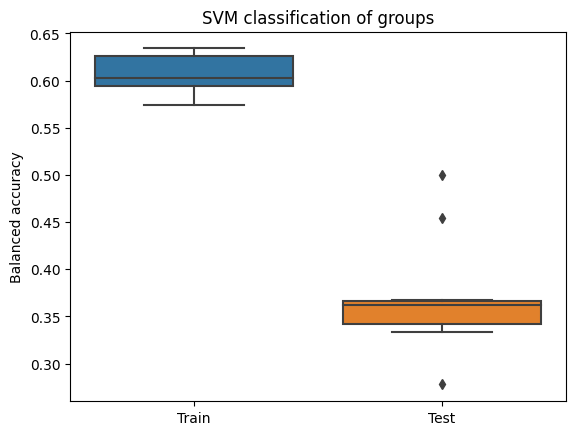

In [106]:
split = StratifiedKFold(10, shuffle=True, random_state=43)
splits = split.split(np.zeros_like(eda_df.group.values), eda_df.group.values)

train_metrics = []
test_metrics = []
for train_idxs, test_idxs in tqdm(splits, total=10):
    train_subjects = eda_df.iloc[train_idxs].index.values
    test_subjects = eda_df.iloc[test_idxs].index.values
    
    train_df = []
    test_df = []
    for s in train_subjects:
        if s in all_feat_df.subject_id.values:
            train_df.append(unwrap_side_feat(all_feat_df[all_feat_df.subject_id == s],
                                            sided_feat_names,
                                            not_sided_feat_names))
        # else:
        #     print(f'Subject {s} not found in the dataset')
    for s in test_subjects:
        if s in all_feat_df.subject_id.values:
            test_df.append(unwrap_side_feat(all_feat_df[all_feat_df.subject_id == s],
                                            sided_feat_names,
                                            not_sided_feat_names))
        # else:
        #     print(f'Subject {s} not found in the dataset')
    train_df = pd.DataFrame(train_df).set_index('subject_id')   
    test_df = pd.DataFrame(test_df).set_index('subject_id')
    
    train_df = train_df.dropna()
    test_df = test_df.dropna()
    
    # dt = SVC(kernel='rbf', C=0.5, probability=False)
    dt = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=43)
    dt.fit(train_df.drop(columns=['group', 'sex', 'handedness']), train_df.group)
    train_pred = dt.predict(train_df.drop(columns=['group', 'sex', 'handedness']))
    test_pred = dt.predict(test_df.drop(columns=['group', 'sex', 'handedness']))
    train_bacc = balanced_accuracy_score(train_df.group, train_pred)
    test_bacc = balanced_accuracy_score(test_df.group, test_pred)
    train_metrics.append(train_bacc)
    test_metrics.append(test_bacc)
    
sns.boxplot(data=[train_metrics, test_metrics])
plt.xticks([0, 1], ['Train', 'Test'])
plt.ylabel('Balanced accuracy')
plt.title('SVM classification of groups')
plt.show()

Try to estimate classification performance on sulci shape only, test (cbl) and both to see if sulci shape adds anything to the classification performance.

Look at the top important features


Having less features (only from right sulci) improves the performance of the model

In [255]:
all_feat_df.columns

Index(['isomap_0', 'isomap_1', 'isomap_2', 'isomap_3', 'isomap_4', 'isomap_5',
       'isomap_6', 'isomap_7', 'isomap_8', 'isomap_9', 'isomap_10',
       'isomap_11', 'isomap_12', 'isomap_13', 'isomap_14', 'isomap_15',
       'isomap_16', 'subject_id', 'side', 'handedness', 'group', 'cbcl_total',
       'cbcl_external', 'cbcl_internal', 'cgas', 'any_diagnosis', 'sex',
       'surface_talairach', 'maxdepth_talairach', 'meandepth_talairach',
       'hull_junction_length_talairach', 'GM_thickness', 'opening',
       'medial_axis_depth_0', 'medial_axis_depth_1', 'medial_axis_depth_2',
       'depth_profile_depth_0', 'depth_profile_depth_1',
       'depth_profile_depth_2', 'medial_axis_profile_0',
       'medial_axis_profile_1', 'medial_axis_profile_2',
       'depth_profile_profile_0', 'depth_profile_profile_1',
       'depth_profile_profile_2'],
      dtype='object')